In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
import scienceplots 
import math

train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)#载入数据60K训练
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)#载入数据10K测试

transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
            ])#将数据转换为张量

train_dataset.transform=transform
test_dataset.transform=transform

m=len(train_dataset)

#随机拆分20%验证12000，80%训练48000
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=128

# 批次。每批128个，那么训练的有375批，验证的94批。测试的79批
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

D:\DeepLearning\Anaconda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#定义GELU卷积网络
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()
        #5*5的卷积核，跨步为1，卷积补零 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        #看上面conv2d的例子，经过卷积图像尺寸不变
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)#  dropout对所有元素中每个元素按照概率0.5更改为零，Dropout2d是对每个通道按照概率0.5置为0，
        
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        #x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为14*14
        x = F.gelu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        #x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为7*7
        x = F.gelu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)
        #把图像扁平化，全连接层32通道，每个7*7，故接线性层nn.Linear(32 * 7 * 7, h1)
        #x = F.relu(self.fc1(x))
        x = F.gelu(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)
        #ReLU输出为h1=96，进入线性层输出10

In [5]:
#初始化参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)#学习率0.002
criterion= nn.CrossEntropyLoss()#交叉熵


#训练加验证，history记录损失和每个epoch的识别精度
historygelu={'GELU_train_loss':[],'GELU_valid_loss':[],'GELU_train_acc':[],'GELU_valid_acc':[]}
num_epochs=20

for epoch in range(num_epochs):
    GELU_train_loss,GELU_train_correct=0.0,0
    model.train()
    #启用batch normalization 和 dropout
    for images, labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()#梯度归零
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()#更新梯度
        GELU_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)#最大化输出得到标签0-9
        GELU_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
    
    GELU_valid_loss, GELU_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        GELU_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        GELU_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    GELU_train_loss = GELU_train_loss / len(train_loader.sampler)#除以48000
    GELU_train_acc = GELU_train_correct / len(train_loader.sampler)*100
    GELU_valid_loss = GELU_valid_loss / len(test_loader.sampler)#除以12000
    GELU_valid_acc = GELU_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         GELU_train_loss,
                                                                                         GELU_valid_loss,
                                                                                         GELU_train_acc,
                                                                                        GELU_valid_acc))
    historygelu['GELU_train_loss'].append(GELU_train_loss)#每次训练和验证记录下来，后面画图   
    historygelu['GELU_valid_loss'].append(GELU_valid_loss)  
    historygelu['GELU_train_acc'].append(GELU_train_acc)  
    historygelu['GELU_valid_acc'].append(GELU_valid_acc)  

D:\DeepLearning\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1/20 	 AVERAGE TL:0.2701 AVERAGE VL:0.0665 	 AVERAGE TA:91.59 %  AVERAGE VA:97.90 %
Epoch:2/20 	 AVERAGE TL:0.0818 AVERAGE VL:0.0392 	 AVERAGE TA:97.53 %  AVERAGE VA:98.65 %
Epoch:3/20 	 AVERAGE TL:0.0597 AVERAGE VL:0.0333 	 AVERAGE TA:98.12 %  AVERAGE VA:98.83 %
Epoch:4/20 	 AVERAGE TL:0.0502 AVERAGE VL:0.0308 	 AVERAGE TA:98.45 %  AVERAGE VA:98.98 %
Epoch:5/20 	 AVERAGE TL:0.0435 AVERAGE VL:0.0303 	 AVERAGE TA:98.66 %  AVERAGE VA:99.07 %
Epoch:6/20 	 AVERAGE TL:0.0382 AVERAGE VL:0.0284 	 AVERAGE TA:98.79 %  AVERAGE VA:99.08 %
Epoch:7/20 	 AVERAGE TL:0.0347 AVERAGE VL:0.0265 	 AVERAGE TA:98.91 %  AVERAGE VA:99.12 %
Epoch:8/20 	 AVERAGE TL:0.0298 AVERAGE VL:0.0269 	 AVERAGE TA:99.00 %  AVERAGE VA:99.18 %
Epoch:9/20 	 AVERAGE TL:0.0270 AVERAGE VL:0.0281 	 AVERAGE TA:99.13 %  AVERAGE VA:99.01 %
Epoch:10/20 	 AVERAGE TL:0.0277 AVERAGE VL:0.0289 	 AVERAGE TA:99.10 %  AVERAGE VA:99.07 %
Epoch:11/20 	 AVERAGE TL:0.0239 AVERAGE VL:0.0255 	 AVERAGE TA:99.20 %  AVERAGE VA:99.20 %
Epoch:12

In [6]:
import pandas as pd
frame1=pd.DataFrame(historygelu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historygelu.csv')

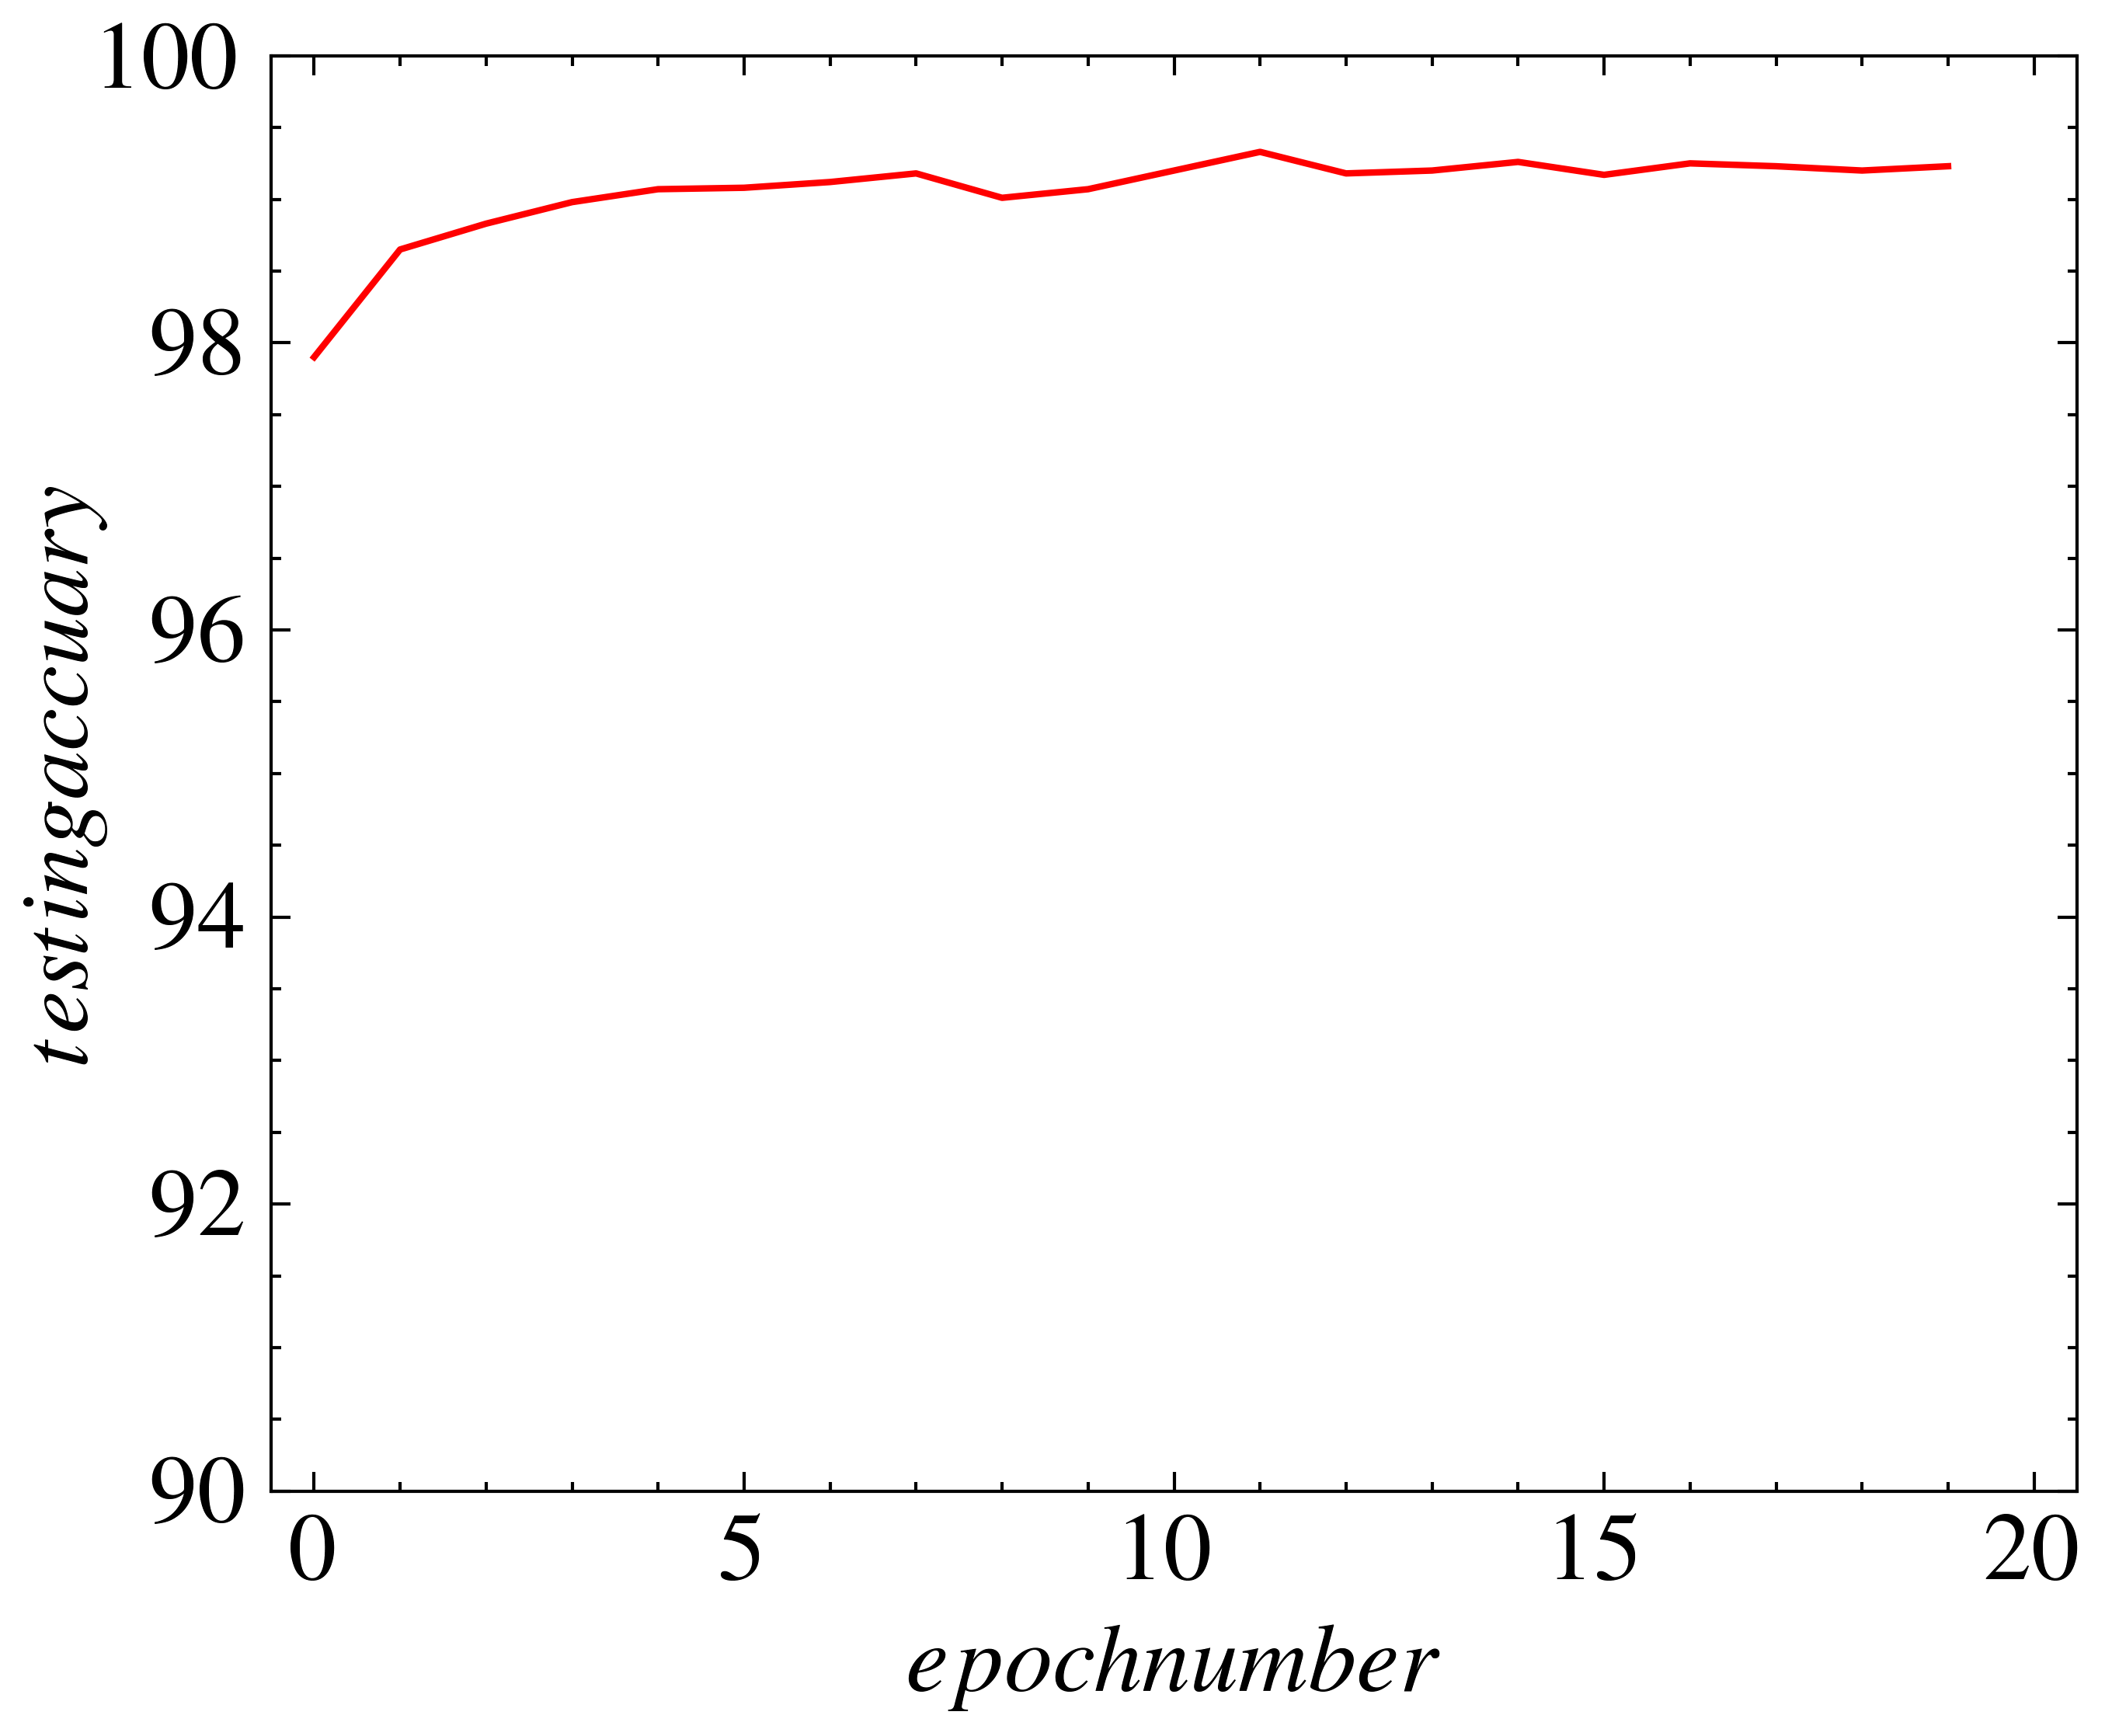

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$epoch number$', fontsize=15)
ax.set_ylabel('$testing accuary$', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(90, 100)

xgelu = range(0, 20)

ygelu = historygelu['GELU_valid_acc']

plt.plot(xgelu, ygelu, '-',color ='r')

plt.show()

In [12]:
#定义relu卷积网络
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()
        #5*5的卷积核，跨步为1，卷积补零 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        #看上面conv2d的例子，经过卷积图像尺寸不变
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)#  dropout对所有元素中每个元素按照概率0.5更改为零，Dropout2d是对每个通道按照概率0.5置为0，
        
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        #x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为14*14
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        #x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为7*7
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)
        #把图像扁平化，全连接层32通道，每个7*7，故接线性层nn.Linear(32 * 7 * 7, h1)
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)
        #ReLU输出为h1=96，进入线性层输出10
        
#初始化参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)#学习率0.002
criterion= nn.CrossEntropyLoss()#交叉熵


#训练加验证，history记录损失和每个epoch的识别精度
historyrelu={'relu_train_loss':[],'relu_valid_loss':[],'relu_train_acc':[],'relu_valid_acc':[]}
num_epochs=20

for epoch in range(num_epochs):
    relu_train_loss,relu_train_correct=0.0,0
    model.train()
    #启用batch normalization 和 dropout
    for images, labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()#梯度归零
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()#更新梯度
        relu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)#最大化输出得到标签0-9
        relu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数     
    
    relu_valid_loss, relu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        relu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        relu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    relu_train_loss = relu_train_loss / len(train_loader.sampler)#除以48000
    relu_train_acc = relu_train_correct / len(train_loader.sampler)*100
    relu_valid_loss = relu_valid_loss / len(test_loader.sampler)#除以12000
    relu_valid_acc = relu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         relu_train_loss,
                                                                                         relu_valid_loss,
                                                                                         relu_train_acc,
                                                                                        relu_valid_acc))
    historyrelu['relu_train_loss'].append(relu_train_loss)#每次训练和验证记录下来，后面画图   
    historyrelu['relu_valid_loss'].append(relu_valid_loss)  
    historyrelu['relu_train_acc'].append(relu_train_acc)  
    historyrelu['relu_valid_acc'].append(relu_valid_acc)  

Epoch:1/20 	 AVERAGE TL:0.2980 AVERAGE VL:0.0737 	 AVERAGE TA:90.68 %  AVERAGE VA:97.58 %
Epoch:2/20 	 AVERAGE TL:0.0934 AVERAGE VL:0.0438 	 AVERAGE TA:97.22 %  AVERAGE VA:98.60 %
Epoch:3/20 	 AVERAGE TL:0.0685 AVERAGE VL:0.0373 	 AVERAGE TA:97.89 %  AVERAGE VA:98.84 %
Epoch:4/20 	 AVERAGE TL:0.0581 AVERAGE VL:0.0332 	 AVERAGE TA:98.21 %  AVERAGE VA:98.85 %
Epoch:5/20 	 AVERAGE TL:0.0512 AVERAGE VL:0.0310 	 AVERAGE TA:98.39 %  AVERAGE VA:98.92 %
Epoch:6/20 	 AVERAGE TL:0.0456 AVERAGE VL:0.0298 	 AVERAGE TA:98.62 %  AVERAGE VA:99.05 %
Epoch:7/20 	 AVERAGE TL:0.0414 AVERAGE VL:0.0292 	 AVERAGE TA:98.74 %  AVERAGE VA:99.10 %
Epoch:8/20 	 AVERAGE TL:0.0380 AVERAGE VL:0.0305 	 AVERAGE TA:98.78 %  AVERAGE VA:99.01 %
Epoch:9/20 	 AVERAGE TL:0.0335 AVERAGE VL:0.0293 	 AVERAGE TA:98.93 %  AVERAGE VA:99.13 %
Epoch:10/20 	 AVERAGE TL:0.0321 AVERAGE VL:0.0281 	 AVERAGE TA:98.93 %  AVERAGE VA:99.16 %
Epoch:11/20 	 AVERAGE TL:0.0311 AVERAGE VL:0.0266 	 AVERAGE TA:98.99 %  AVERAGE VA:99.18 %
Epoch:12

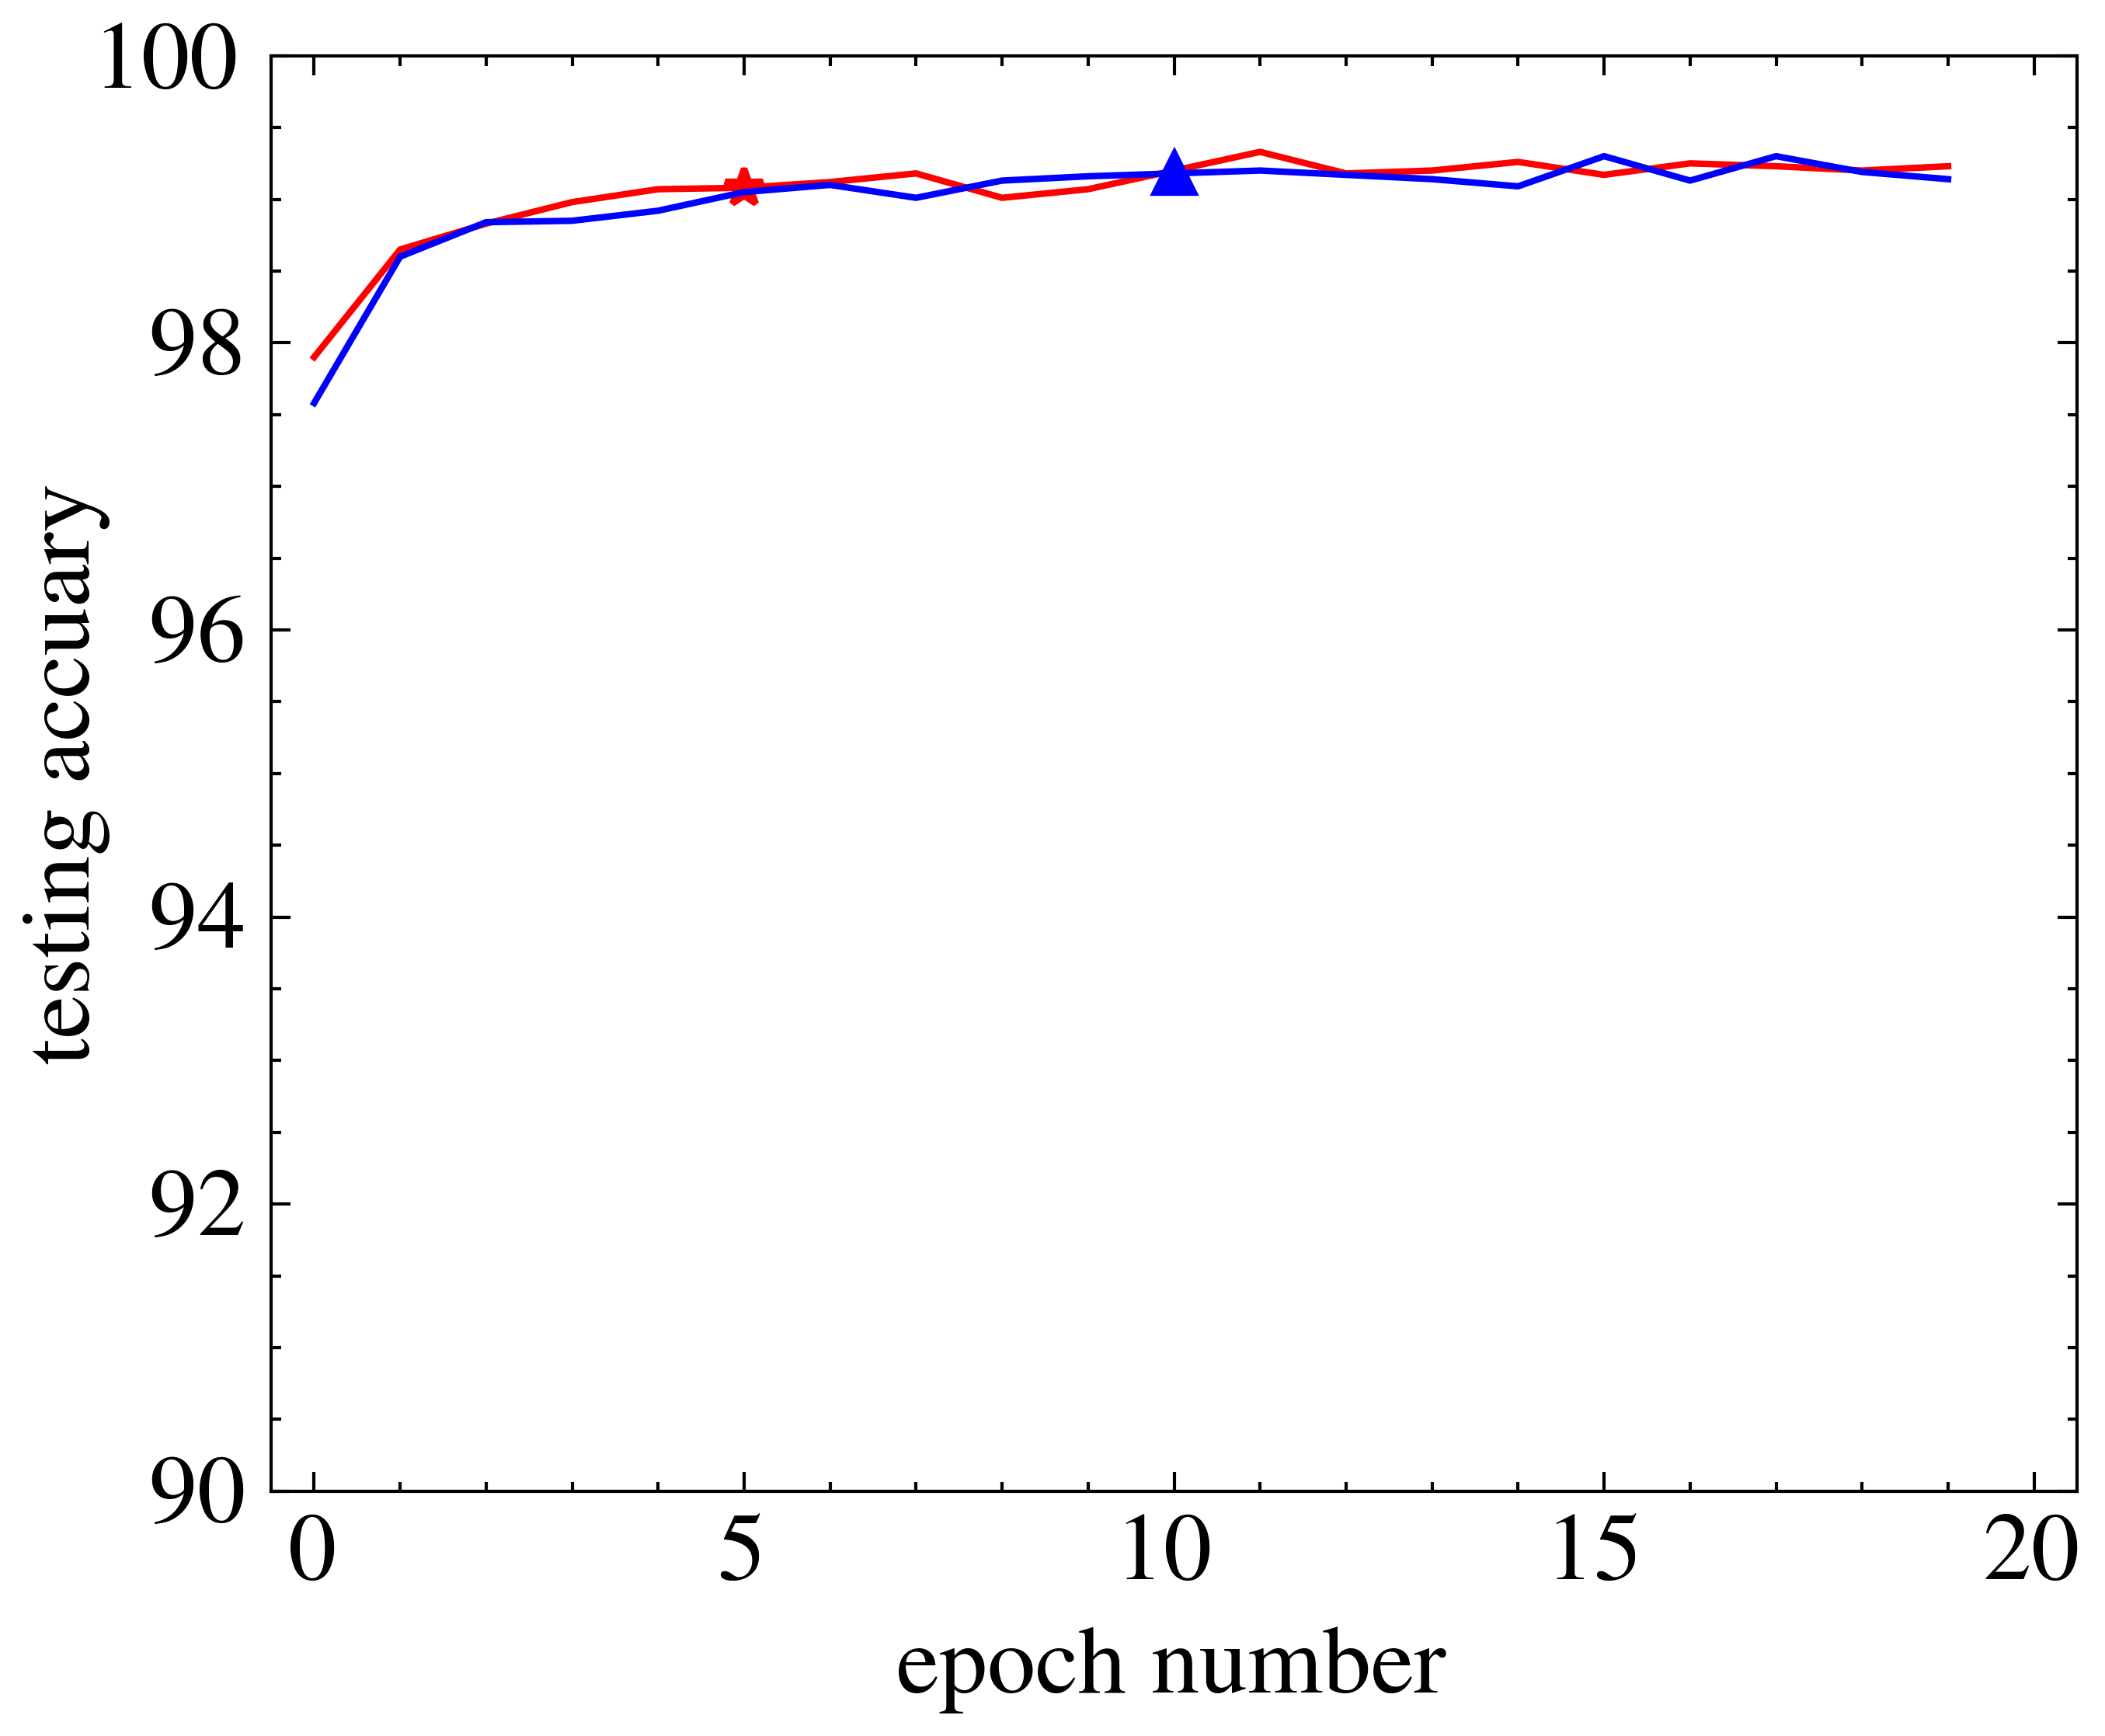

In [16]:
import pandas as pd
frame1=pd.DataFrame(historyrelu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historyrelu.csv')

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('testing accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(90, 100)

xgelu = range(0, 20)
ygelu = historygelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='r')
plt.plot(xgelu[5], ygelu[5], '*',color ='r')

xrelu = range(0, 20)
yrelu = historyrelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[10], yrelu[10], '^',color ='b')

plt.show()

In [17]:
#定义sigmoid卷积网络
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()
        #5*5的卷积核，跨步为1，卷积补零 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        #看上面conv2d的例子，经过卷积图像尺寸不变
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)#  dropout对所有元素中每个元素按照概率0.5更改为零，Dropout2d是对每个通道按照概率0.5置为0，
        
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        #x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为14*14
        x = torch.sigmoid(F.max_pool2d(self.conv1(x),kernel_size = 2))
        #x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为7*7
        x = torch.sigmoid(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)
        #把图像扁平化，全连接层32通道，每个7*7，故接线性层nn.Linear(32 * 7 * 7, h1)
        #x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)
        #ReLU输出为h1=96，进入线性层输出10
        

        
        
#初始化参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)#学习率0.002
criterion= nn.CrossEntropyLoss()#交叉熵



#训练加验证，history记录损失和每个epoch的识别精度
historysigmoid={'SIGMOID_train_loss':[],'SIGMOID_valid_loss':[],'SIGMOID_train_acc':[],'SIGMOID_valid_acc':[]}
num_epochs=20

for epoch in range(num_epochs):
    SIGMOID_train_loss,SIGMOID_train_correct=0.0,0
    model.train()
    #启用batch normalization 和 dropout
    for images, labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()#梯度归零
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()#更新梯度
        SIGMOID_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)#最大化输出得到标签0-9
        SIGMOID_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数    
    
    SIGMOID_valid_loss, SIGMOID_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        SIGMOID_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        SIGMOID_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    SIGMOID_train_loss = SIGMOID_train_loss / len(train_loader.sampler)#除以48000
    SIGMOID_train_acc = SIGMOID_train_correct / len(train_loader.sampler)*100
    SIGMOID_valid_loss = SIGMOID_valid_loss / len(test_loader.sampler)#除以12000
    SIGMOID_valid_acc = SIGMOID_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         SIGMOID_train_loss,
                                                                                         SIGMOID_valid_loss,
                                                                                         SIGMOID_train_acc,
                                                                                        SIGMOID_valid_acc))
    historysigmoid['SIGMOID_train_loss'].append(SIGMOID_train_loss)#每次训练和验证记录下来，后面画图   
    historysigmoid['SIGMOID_valid_loss'].append(SIGMOID_valid_loss)  
    historysigmoid['SIGMOID_train_acc'].append(SIGMOID_train_acc)  
    historysigmoid['SIGMOID_valid_acc'].append(SIGMOID_valid_acc)  

Epoch:1/20 	 AVERAGE TL:1.4879 AVERAGE VL:0.3456 	 AVERAGE TA:47.88 %  AVERAGE VA:90.32 %
Epoch:2/20 	 AVERAGE TL:0.2892 AVERAGE VL:0.1699 	 AVERAGE TA:91.40 %  AVERAGE VA:94.86 %
Epoch:3/20 	 AVERAGE TL:0.1882 AVERAGE VL:0.1133 	 AVERAGE TA:94.34 %  AVERAGE VA:96.42 %
Epoch:4/20 	 AVERAGE TL:0.1458 AVERAGE VL:0.0887 	 AVERAGE TA:95.57 %  AVERAGE VA:97.10 %
Epoch:5/20 	 AVERAGE TL:0.1231 AVERAGE VL:0.0752 	 AVERAGE TA:96.30 %  AVERAGE VA:97.47 %
Epoch:6/20 	 AVERAGE TL:0.1059 AVERAGE VL:0.0664 	 AVERAGE TA:96.68 %  AVERAGE VA:97.83 %
Epoch:7/20 	 AVERAGE TL:0.0936 AVERAGE VL:0.0612 	 AVERAGE TA:97.11 %  AVERAGE VA:97.92 %
Epoch:8/20 	 AVERAGE TL:0.0869 AVERAGE VL:0.0543 	 AVERAGE TA:97.31 %  AVERAGE VA:98.17 %
Epoch:9/20 	 AVERAGE TL:0.0785 AVERAGE VL:0.0502 	 AVERAGE TA:97.50 %  AVERAGE VA:98.23 %
Epoch:10/20 	 AVERAGE TL:0.0739 AVERAGE VL:0.0486 	 AVERAGE TA:97.64 %  AVERAGE VA:98.33 %
Epoch:11/20 	 AVERAGE TL:0.0682 AVERAGE VL:0.0437 	 AVERAGE TA:97.92 %  AVERAGE VA:98.53 %
Epoch:12

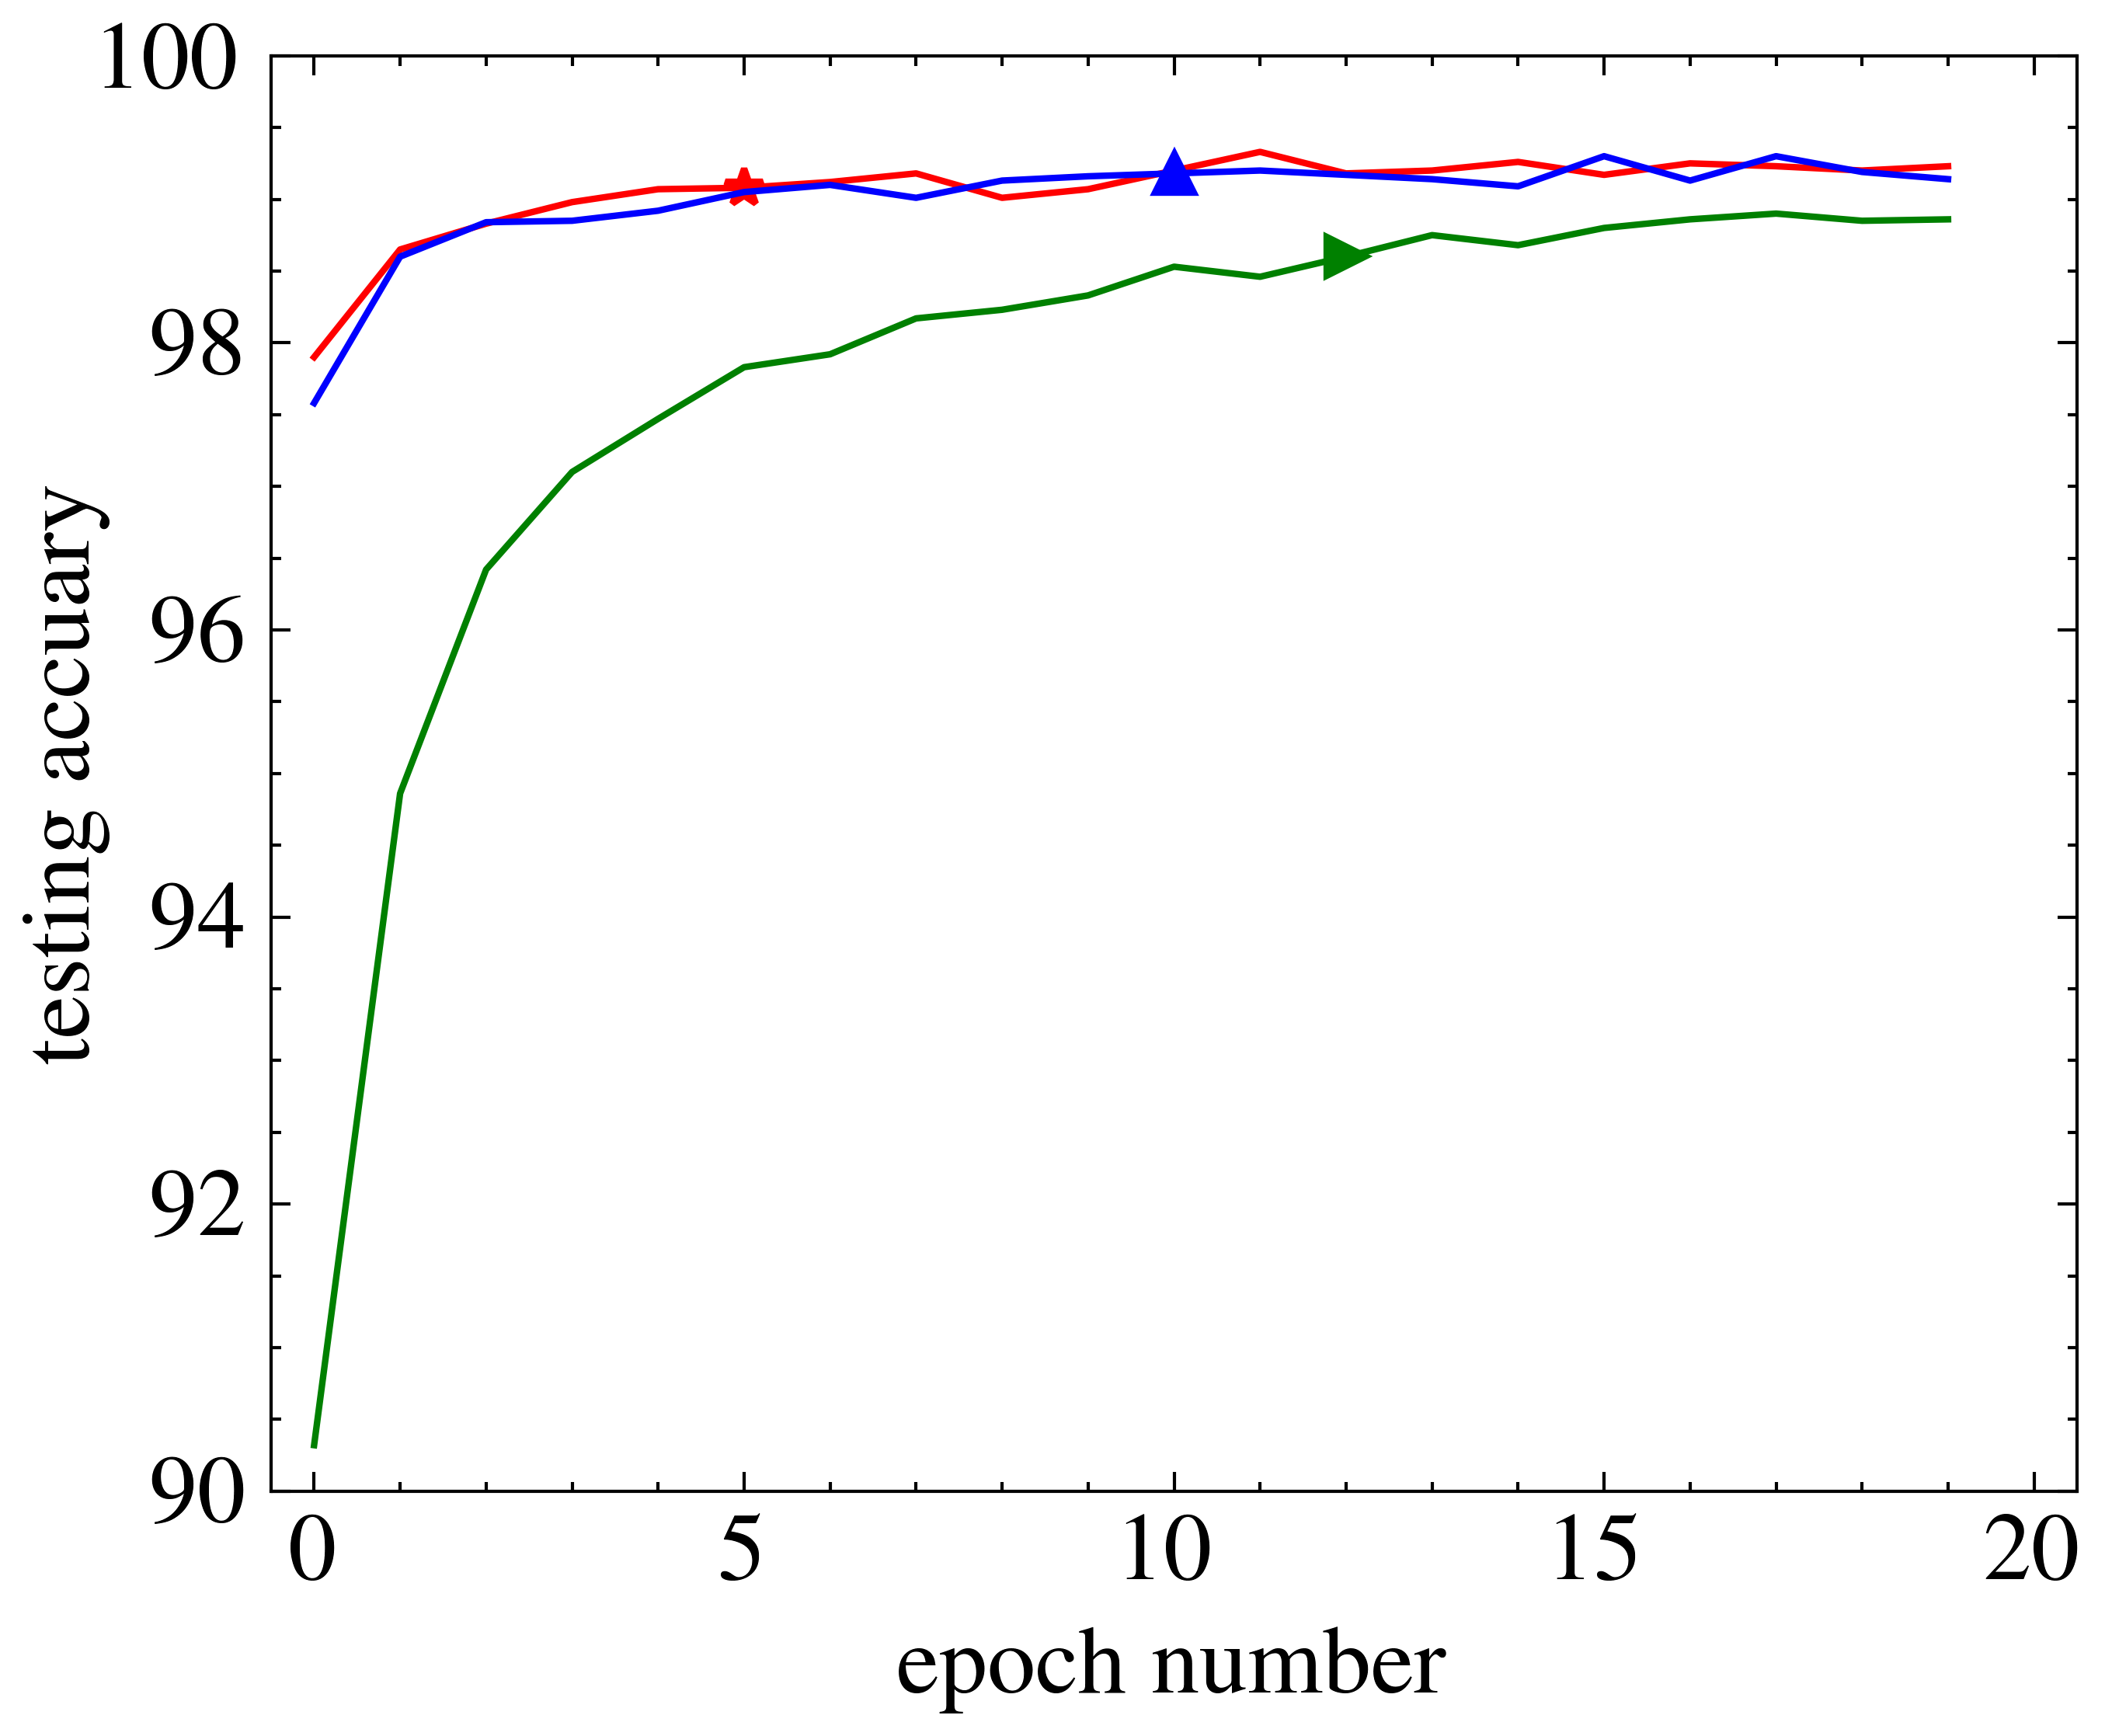

In [18]:
import pandas as pd
frame1=pd.DataFrame(historysigmoid)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historysigmoid.csv')

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('testing accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(90, 100)

xgelu = range(0, 20)
ygelu = historygelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='r')
plt.plot(xgelu[5], ygelu[5], '*',color ='r')

xrelu = range(0, 20)
yrelu = historyrelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[10], yrelu[10], '^',color ='b')

xsigmoid = range(0, 20)
ysigmoid = historysigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='g')
plt.plot(xsigmoid[12], ysigmoid[12], '>',color ='g')

plt.show()

In [22]:
#定义PReLU卷积网络
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()
        #5*5的卷积核，跨步为1，卷积补零 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        #看上面conv2d的例子，经过卷积图像尺寸不变
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)#  dropout对所有元素中每个元素按照概率0.5更改为零，Dropout2d是对每个通道按照概率0.5置为0，
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        #x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为14*14
        x = self.prelu1(torch.max_pool2d(self.conv1(x),kernel_size = 2))
        #x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为7*7
        x = self.prelu2(torch.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)
        #把图像扁平化，全连接层32通道，每个7*7，故接线性层nn.Linear(32 * 7 * 7, h1)
        #x = F.relu(self.fc1(x))
        x = self.prelu3(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)
        #ReLU输出为h1=96，进入线性层输出10
        

        
        
#初始化参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)#学习率0.002
criterion= nn.CrossEntropyLoss()#交叉熵



#训练加验证，history记录损失和每个epoch的识别精度
historyPrelu={'Prelu_train_loss':[],'Prelu_valid_loss':[],'Prelu_train_acc':[],'Prelu_valid_acc':[]}
num_epochs=20

for epoch in range(num_epochs):
    Prelu_train_loss,Prelu_train_correct=0.0,0
    model.train()
    #启用batch normalization 和 dropout
    for images, labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()#梯度归零
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()#更新梯度
        Prelu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)#最大化输出得到标签0-9
        Prelu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数    
    
    Prelu_valid_loss, Prelu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        Prelu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        Prelu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    Prelu_train_loss = Prelu_train_loss / len(train_loader.sampler)#除以48000
    Prelu_train_acc = Prelu_train_correct / len(train_loader.sampler)*100
    Prelu_valid_loss = Prelu_valid_loss / len(test_loader.sampler)#除以12000
    Prelu_valid_acc = Prelu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         Prelu_train_loss,
                                                                                         Prelu_valid_loss,
                                                                                         Prelu_train_acc,
                                                                                        Prelu_valid_acc))
    historyPrelu['Prelu_train_loss'].append(Prelu_train_loss)#每次训练和验证记录下来，后面画图   
    historyPrelu['Prelu_valid_loss'].append(Prelu_valid_loss)  
    historyPrelu['Prelu_train_acc'].append(Prelu_train_acc)  
    historyPrelu['Prelu_valid_acc'].append(Prelu_valid_acc)  

Epoch:1/20 	 AVERAGE TL:0.2665 AVERAGE VL:0.0693 	 AVERAGE TA:91.84 %  AVERAGE VA:97.80 %
Epoch:2/20 	 AVERAGE TL:0.0867 AVERAGE VL:0.0461 	 AVERAGE TA:97.36 %  AVERAGE VA:98.54 %
Epoch:3/20 	 AVERAGE TL:0.0623 AVERAGE VL:0.0382 	 AVERAGE TA:98.08 %  AVERAGE VA:98.81 %
Epoch:4/20 	 AVERAGE TL:0.0536 AVERAGE VL:0.0338 	 AVERAGE TA:98.34 %  AVERAGE VA:98.79 %
Epoch:5/20 	 AVERAGE TL:0.0460 AVERAGE VL:0.0283 	 AVERAGE TA:98.58 %  AVERAGE VA:99.17 %
Epoch:6/20 	 AVERAGE TL:0.0397 AVERAGE VL:0.0291 	 AVERAGE TA:98.76 %  AVERAGE VA:99.10 %
Epoch:7/20 	 AVERAGE TL:0.0380 AVERAGE VL:0.0289 	 AVERAGE TA:98.81 %  AVERAGE VA:99.02 %
Epoch:8/20 	 AVERAGE TL:0.0338 AVERAGE VL:0.0302 	 AVERAGE TA:98.97 %  AVERAGE VA:98.99 %
Epoch:9/20 	 AVERAGE TL:0.0319 AVERAGE VL:0.0295 	 AVERAGE TA:98.93 %  AVERAGE VA:99.11 %
Epoch:10/20 	 AVERAGE TL:0.0291 AVERAGE VL:0.0275 	 AVERAGE TA:99.05 %  AVERAGE VA:99.18 %
Epoch:11/20 	 AVERAGE TL:0.0257 AVERAGE VL:0.0270 	 AVERAGE TA:99.14 %  AVERAGE VA:99.18 %
Epoch:12

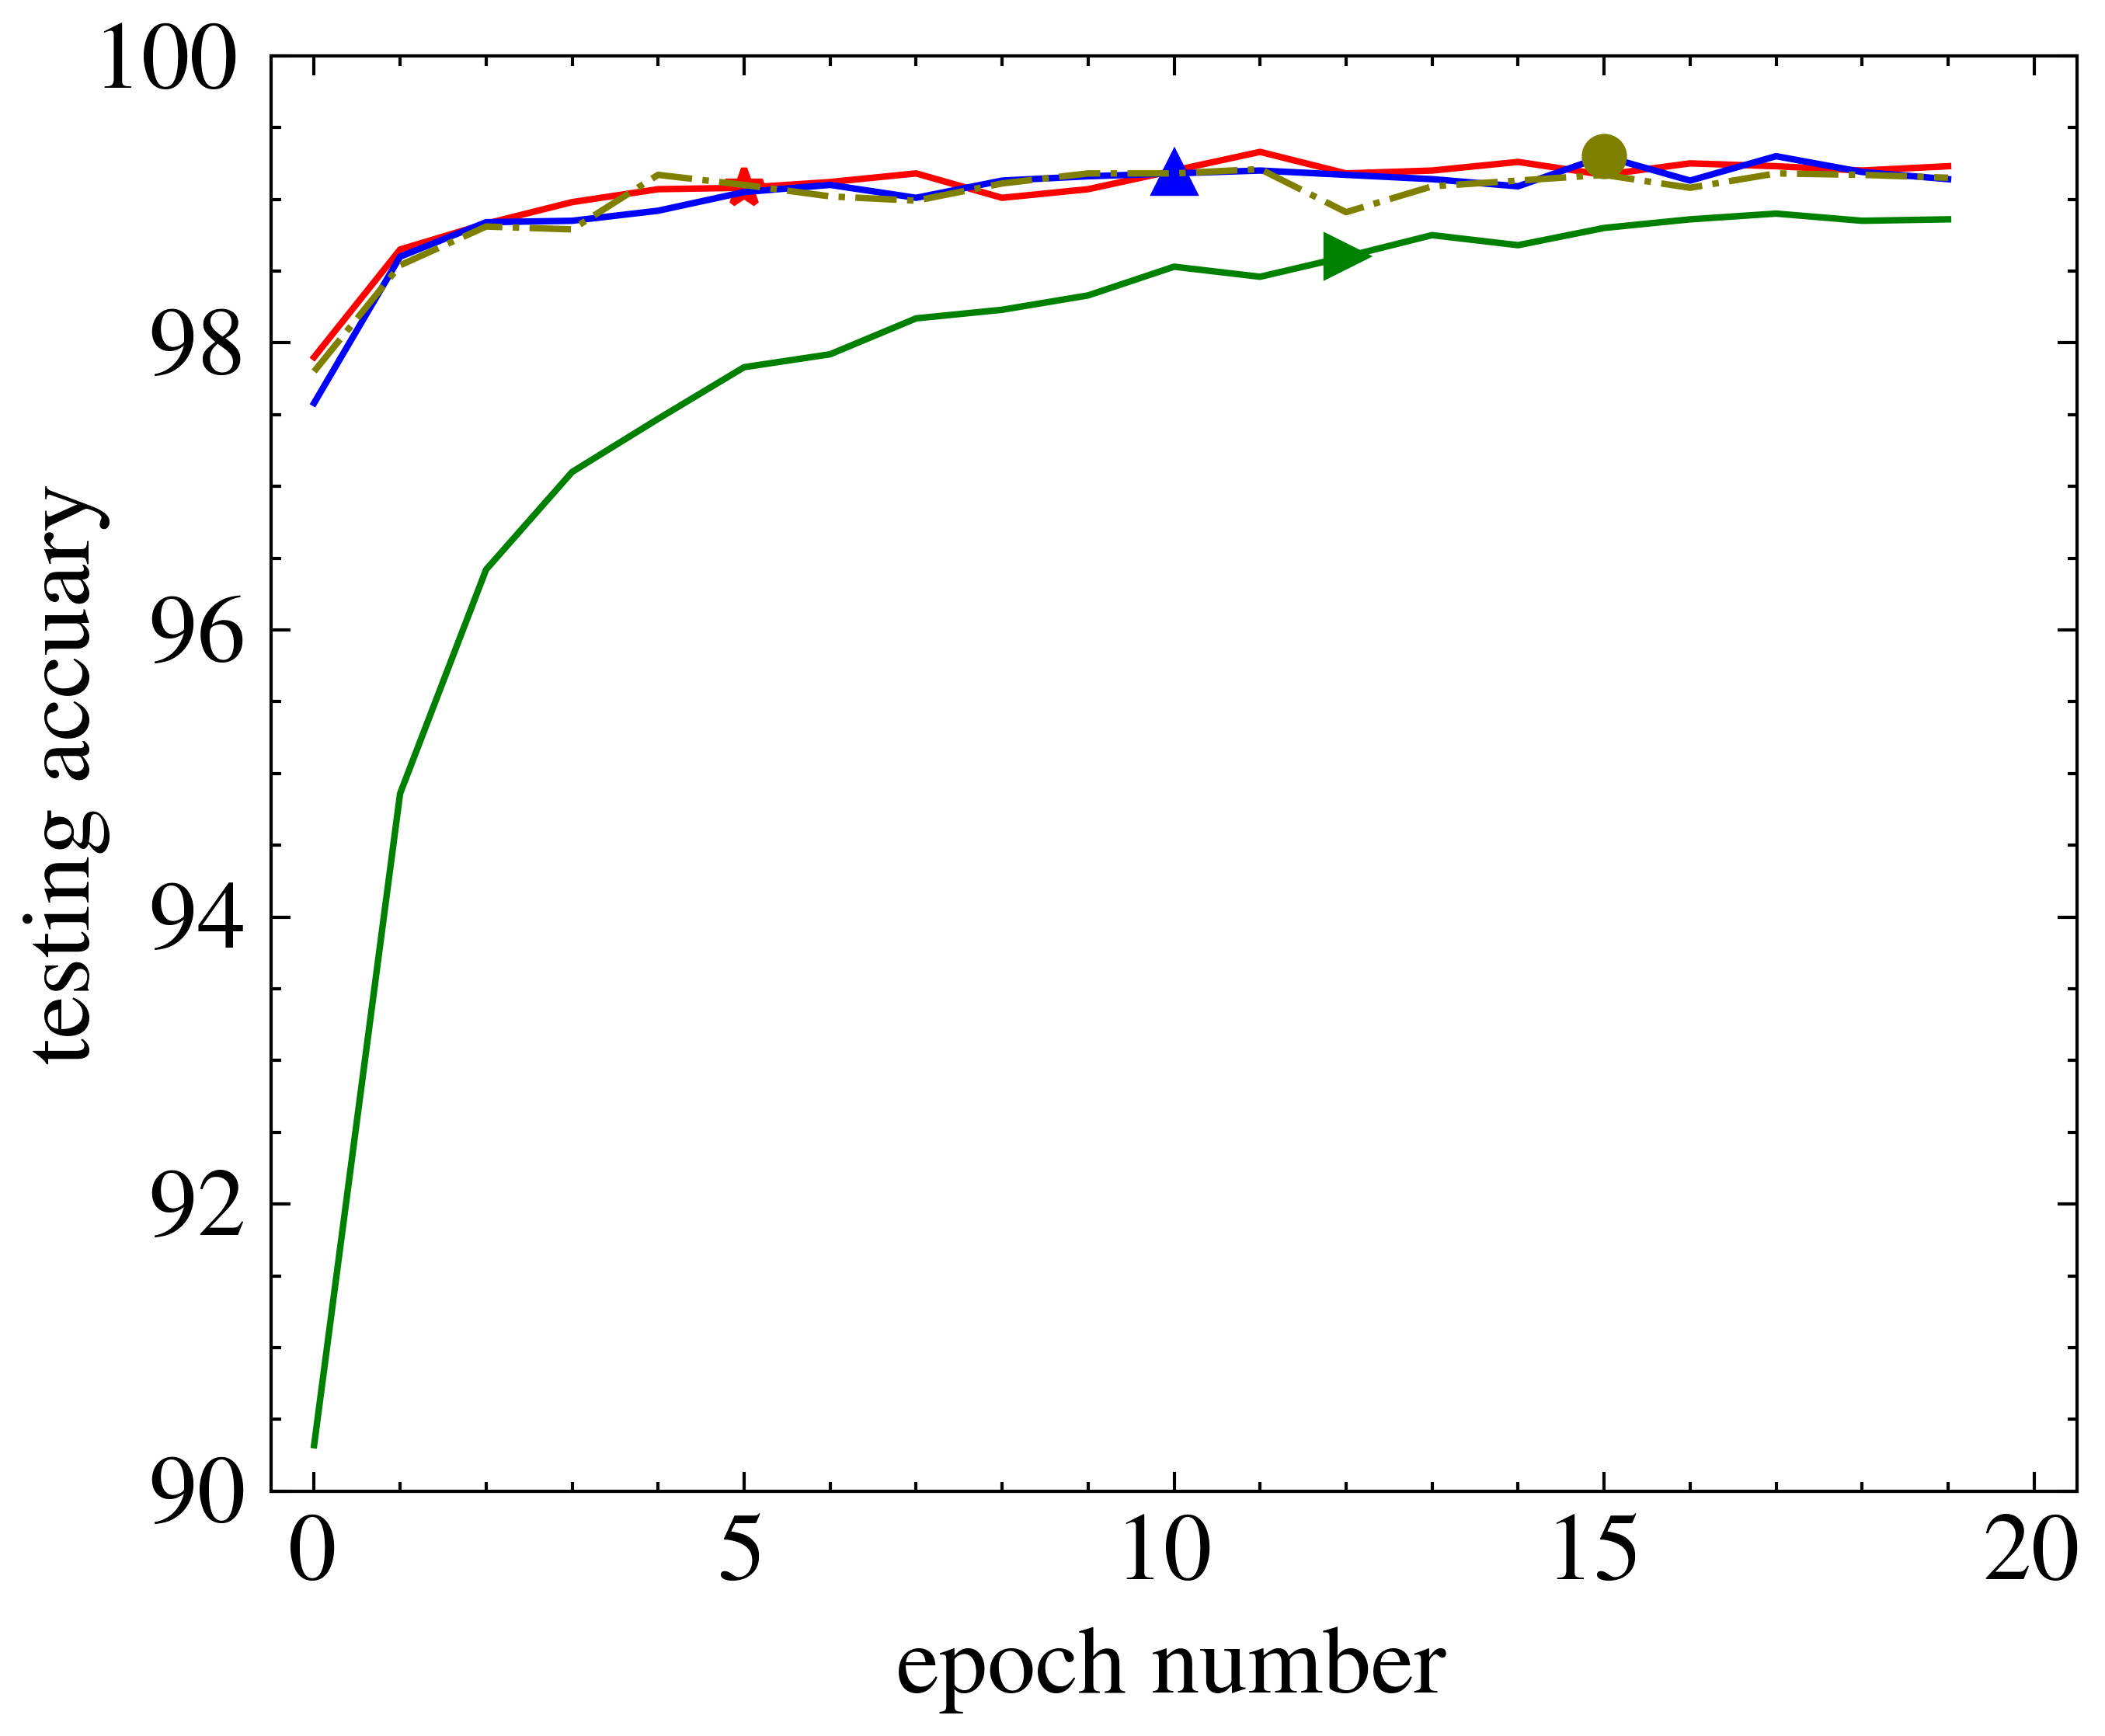

In [26]:
import pandas as pd
frame1=pd.DataFrame(historyPrelu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historyPrelu.csv')

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('testing accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(90, 100)

xgelu = range(0, 20)
ygelu = historygelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='r')
plt.plot(xgelu[5], ygelu[5], '*',color ='r')

xrelu = range(0, 20)
yrelu = historyrelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[10], yrelu[10], '^',color ='b')

xsigmoid = range(0, 20)
ysigmoid = historysigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='g')
plt.plot(xsigmoid[12], ysigmoid[12], '>',color ='g')

xPrelu = range(0, 20)
yPrelu = historyPrelu['Prelu_valid_acc']
plt.plot(xPrelu, yPrelu, '-.',color ='olive')
plt.plot(xrelu[15], yrelu[15], 'o',color ='olive')

plt.show()

In [37]:
import math

class GEU(nn.Module):  # 第一类激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # 1个可学习参数 sigma
        #self.theta = nn.Parameter(torch.randn(1, width))
    def forward(self, input):
        temp = 0.5+torch.erf((input)/self.sigma/math.sqrt(2))/2  # 前向传播
        return temp


#定义GEU卷积网络
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()
        #5*5的卷积核，跨步为1，卷积补零 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        #看上面conv2d的例子，经过卷积图像尺寸不变
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)#  dropout对所有元素中每个元素按照概率0.5更改为零，Dropout2d是对每个通道按照概率0.5置为0，
        self.geu1 = GEU()
        self.geu2 = GEU()
        self.geu3 = GEU()
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        #x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为14*14
        #x = F.gelu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = self.geu1(torch.max_pool2d(self.conv1(x),kernel_size = 2))
        #x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为7*7
        #x = F.gelu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.geu2(torch.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)
        #把图像扁平化，全连接层32通道，每个7*7，故接线性层nn.Linear(32 * 7 * 7, h1)
        #x = F.relu(self.fc1(x))
        x = self.geu3(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)
        #输出为h1=96，进入线性层输出10

In [53]:
#初始化参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)#学习率0.002
criterion= nn.CrossEntropyLoss()#交叉熵

z1=model.geu1.sigma 
nn.init.constant_(z1,2.5)

z2=model.geu2.sigma 
nn.init.constant_(z2,2.5)

z3=model.geu3.sigma 
nn.init.constant_(z3,0.8)





historygeu={'geu_train_loss':[],'geu_valid_loss':[],'geu_train_acc':[],'geu_valid_acc':[]}
num_epochs=20

for epoch in range(num_epochs):
    geu_train_loss,geu_train_correct=0.0,0
    model.train()
    #启用batch normalization 和 dropout
    for images, labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()#梯度归零
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()#更新梯度
        geu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)#最大化输出得到标签0-9
        geu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
    
    
    geu_valid_loss, geu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        geu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        geu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    geu_train_loss = geu_train_loss / len(train_loader.sampler)#除以48000
    geu_train_acc = geu_train_correct / len(train_loader.sampler)*100
    geu_valid_loss = geu_valid_loss / len(test_loader.sampler)#除以12000
    geu_valid_acc = geu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         geu_train_loss,
                                                                                         geu_valid_loss,
                                                                                         geu_train_acc,
                                                                                        geu_valid_acc))
    historygeu['geu_train_loss'].append(geu_train_loss)#每次训练和验证记录下来，后面画图   
    historygeu['geu_valid_loss'].append(geu_valid_loss)  
    historygeu['geu_train_acc'].append(geu_train_acc)  
    historygeu['geu_valid_acc'].append(geu_valid_acc)  

Epoch:1/20 	 AVERAGE TL:2.3132 AVERAGE VL:2.3059 	 AVERAGE TA:10.12 %  AVERAGE VA:10.09 %
Epoch:2/20 	 AVERAGE TL:1.6554 AVERAGE VL:0.2509 	 AVERAGE TA:39.67 %  AVERAGE VA:92.86 %
Epoch:3/20 	 AVERAGE TL:0.2115 AVERAGE VL:0.1001 	 AVERAGE TA:93.77 %  AVERAGE VA:96.96 %
Epoch:4/20 	 AVERAGE TL:0.1257 AVERAGE VL:0.0688 	 AVERAGE TA:96.18 %  AVERAGE VA:98.02 %
Epoch:5/20 	 AVERAGE TL:0.0957 AVERAGE VL:0.0546 	 AVERAGE TA:97.04 %  AVERAGE VA:98.32 %
Epoch:6/20 	 AVERAGE TL:0.0807 AVERAGE VL:0.0474 	 AVERAGE TA:97.54 %  AVERAGE VA:98.50 %
Epoch:7/20 	 AVERAGE TL:0.0703 AVERAGE VL:0.0436 	 AVERAGE TA:97.84 %  AVERAGE VA:98.57 %
Epoch:8/20 	 AVERAGE TL:0.0647 AVERAGE VL:0.0373 	 AVERAGE TA:98.04 %  AVERAGE VA:98.76 %
Epoch:9/20 	 AVERAGE TL:0.0570 AVERAGE VL:0.0378 	 AVERAGE TA:98.26 %  AVERAGE VA:98.79 %
Epoch:10/20 	 AVERAGE TL:0.0525 AVERAGE VL:0.0358 	 AVERAGE TA:98.39 %  AVERAGE VA:98.80 %
Epoch:11/20 	 AVERAGE TL:0.0474 AVERAGE VL:0.0329 	 AVERAGE TA:98.52 %  AVERAGE VA:99.01 %
Epoch:12

In [54]:
import pandas as pd
frame1=pd.DataFrame(historygeu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historygeu.csv')

{'geu_train_loss': [2.3132349122365317, 1.655390588204066, 0.21154455702503522, 0.12572719334562618, 0.09571824347476164, 0.0807032921637098, 0.07033925248682499, 0.06469925474127133, 0.056974871789415675, 0.0525376757333676, 0.047420122003803654, 0.044816592099765934, 0.042360506311059, 0.037129041720802586, 0.03555985341221094, 0.037079161594932276, 0.03262541608978063, 0.032801970646095774, 0.032253506089871126, 0.028118129570347566], 'geu_valid_loss': [2.3058505870819093, 0.2508544616222382, 0.10013183372318744, 0.0687658019259572, 0.05456428141593933, 0.047422387892007825, 0.04360039244368672, 0.037331816916167736, 0.03782586434297264, 0.03582590695358813, 0.03285120583176613, 0.0316198399185203, 0.030005065505951643, 0.030202824586629866, 0.028189039956778288, 0.02887914582528174, 0.027007948696613313, 0.02759220732152462, 0.02699745871461928, 0.02660706775560975], 'geu_train_acc': [10.11875, 39.66875, 93.77291666666666, 96.17708333333333, 97.0375, 97.5375, 97.84166666666667, 98.

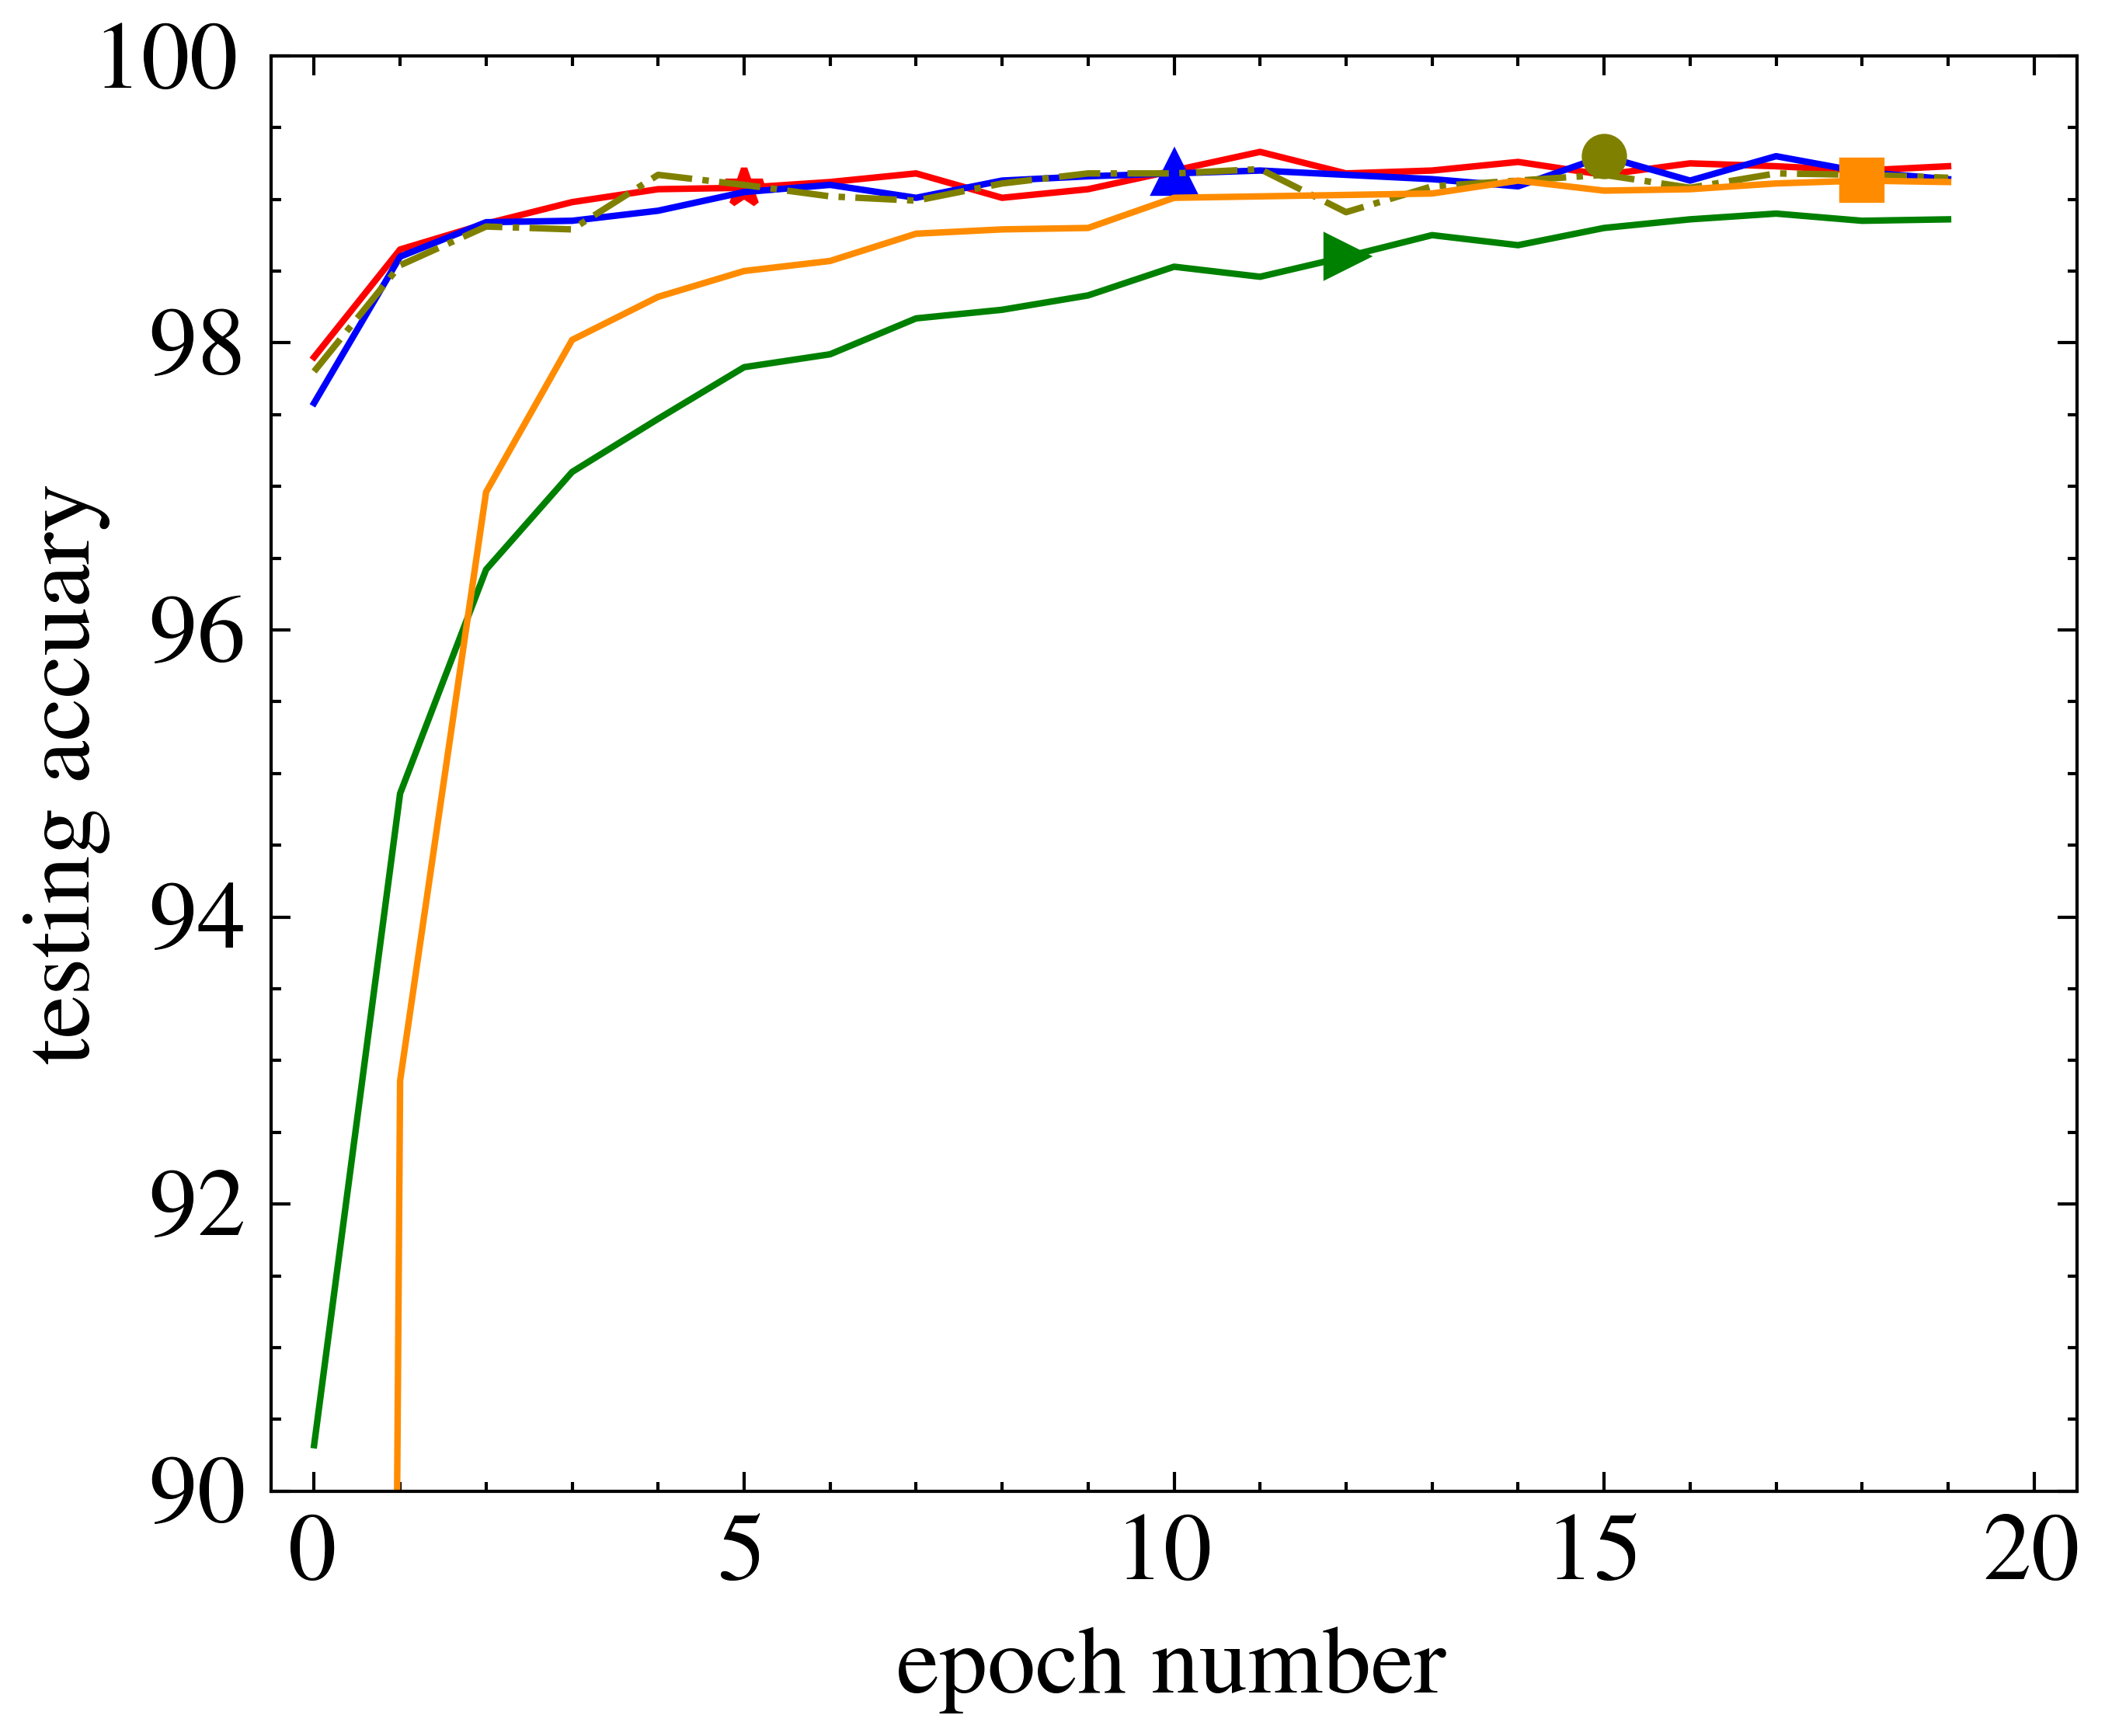

In [6]:
import pandas as pd
historygelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historygelu.csv')
historyrelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historyrelu.csv')
historysigmoid=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historysigmoid.csv')
historyPrelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historyPrelu.csv')
historygeu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historygeu.csv')
import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('testing accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(90, 100)

xgelu = range(0, 20)
ygelu = historygelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='r')
plt.plot(xgelu[5], ygelu[5], '*',color ='r')

xrelu = range(0, 20)
yrelu = historyrelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[10], yrelu[10], '^',color ='b')

xsigmoid = range(0, 20)
ysigmoid = historysigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='g')
plt.plot(xsigmoid[12], ysigmoid[12], '>',color ='g')

xPrelu = range(0, 20)
yPrelu = historyPrelu['Prelu_valid_acc']
plt.plot(xPrelu, yPrelu, '-.',color ='olive')
plt.plot(xrelu[15], yrelu[15], 'o',color ='olive')


xgeu = range(0, 20)
ygeu = historygeu['geu_valid_acc']
plt.plot(xgeu, ygeu, '-',color ='darkorange')
plt.plot(xgeu[18], ygeu[18], 's',color ='darkorange')


plt.show()

In [56]:
print(historygeu)

    Unnamed: 0  geu_train_loss  geu_valid_loss  geu_train_acc  geu_valid_acc
0            0        2.313235        2.305851      10.118750          10.09
1            1        1.655391        0.250854      39.668750          92.86
2            2        0.211545        0.100132      93.772917          96.96
3            3        0.125727        0.068766      96.177083          98.02
4            4        0.095718        0.054564      97.037500          98.32
5            5        0.080703        0.047422      97.537500          98.50
6            6        0.070339        0.043600      97.841667          98.57
7            7        0.064699        0.037332      98.039583          98.76
8            8        0.056975        0.037826      98.260417          98.79
9            9        0.052538        0.035826      98.391667          98.80
10          10        0.047420        0.032851      98.522917          99.01
11          11        0.044817        0.031620      98.608333          99.02

In [57]:
print(historyrelu)

    Unnamed: 0  relu_train_loss  relu_valid_loss  relu_train_acc  \
0            0         0.298030         0.073700       90.677083   
1            1         0.093420         0.043824       97.220833   
2            2         0.068454         0.037255       97.887500   
3            3         0.058056         0.033241       98.208333   
4            4         0.051173         0.031015       98.389583   
5            5         0.045628         0.029836       98.625000   
6            6         0.041432         0.029177       98.737500   
7            7         0.037998         0.030482       98.781250   
8            8         0.033462         0.029278       98.933333   
9            9         0.032097         0.028096       98.933333   
10          10         0.031081         0.026605       98.987500   
11          11         0.028051         0.029625       99.112500   
12          12         0.027826         0.029596       99.131250   
13          13         0.028944         0.031170

In [58]:
print(historygelu)

    Unnamed: 0  GELU_train_loss  GELU_valid_loss  GELU_train_acc  \
0            0         0.270110         0.066548       91.593750   
1            1         0.081819         0.039174       97.529167   
2            2         0.059657         0.033329       98.125000   
3            3         0.050185         0.030832       98.454167   
4            4         0.043505         0.030285       98.658333   
5            5         0.038190         0.028404       98.793750   
6            6         0.034650         0.026472       98.906250   
7            7         0.029787         0.026859       99.002083   
8            8         0.027035         0.028103       99.129167   
9            9         0.027714         0.028934       99.102083   
10          10         0.023929         0.025492       99.197917   
11          11         0.024317         0.022383       99.220833   
12          12         0.020769         0.028141       99.345833   
13          13         0.020755         0.031357

In [59]:
print(historyPrelu)

    Unnamed: 0  Prelu_train_loss  Prelu_valid_loss  Prelu_train_acc  \
0            0          0.266483          0.069288        91.841667   
1            1          0.086678          0.046100        97.360417   
2            2          0.062283          0.038183        98.083333   
3            3          0.053596          0.033783        98.337500   
4            4          0.046042          0.028335        98.577083   
5            5          0.039718          0.029110        98.756250   
6            6          0.038005          0.028898        98.812500   
7            7          0.033830          0.030177        98.972917   
8            8          0.031894          0.029489        98.931250   
9            9          0.029115          0.027518        99.050000   
10          10          0.025724          0.026962        99.141667   
11          11          0.024825          0.028277        99.235417   
12          12          0.026073          0.034387        99.095833   
13    

In [60]:
print(historysigmoid)

    Unnamed: 0  SIGMOID_train_loss  SIGMOID_valid_loss  SIGMOID_train_acc  \
0            0            1.487876            0.345608          47.877083   
1            1            0.289208            0.169950          91.397917   
2            2            0.188201            0.113312          94.341667   
3            3            0.145791            0.088654          95.572917   
4            4            0.123139            0.075180          96.300000   
5            5            0.105879            0.066387          96.681250   
6            6            0.093562            0.061185          97.106250   
7            7            0.086923            0.054261          97.310417   
8            8            0.078507            0.050168          97.502083   
9            9            0.073899            0.048624          97.639583   
10          10            0.068157            0.043662          97.922917   
11          11            0.063768            0.044142          97.891667   

In [7]:
import math

class Pgelu(nn.Module): #带参数的gelu激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1)) #两个可学习参数 sigma 和 theta

    def forward(self, input):
        #temp1=self.sigma*torch.exp(-input*input/2/self.sigma/self.sigma)/2.506628 #具体表达式
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2



#定义GEU卷积网络
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()
        #5*5的卷积核，跨步为1，卷积补零 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        #看上面conv2d的例子，经过卷积图像尺寸不变
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)#  dropout对所有元素中每个元素按照概率0.5更改为零，Dropout2d是对每个通道按照概率0.5置为0，
        self.pgelu1 = Pgelu()
        self.pgelu2 = Pgelu()
        self.pgelu3 = Pgelu()
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        #x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为14*14
        #x = F.gelu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = self.pgelu1(torch.max_pool2d(self.conv1(x),kernel_size = 2))
        #x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))#图像尺寸高和宽各自下降1/2，为7*7
        #x = F.gelu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.pgelu2(torch.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)
        #把图像扁平化，全连接层32通道，每个7*7，故接线性层nn.Linear(32 * 7 * 7, h1)
        #x = F.relu(self.fc1(x))
        x = self.pgelu3(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)
        #输出为h1=96，进入线性层输出10

In [32]:
#初始化参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)#学习率0.002
criterion= nn.CrossEntropyLoss()#交叉熵

z1=model.pgelu1.sigma 
nn.init.constant_(z1,2)

z2=model.pgelu2.sigma 
nn.init.constant_(z2,2)

z3=model.pgelu3.sigma 
nn.init.constant_(z3,5)



historypgelu={'pgelu_train_loss':[],'pgelu_valid_loss':[],'pgelu_train_acc':[],'pgelu_valid_acc':[]}
num_epochs=20

for epoch in range(num_epochs):
    pgelu_train_loss,pgelu_train_correct=0.0,0
    model.train()
    #启用batch normalization 和 dropout
    for images, labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()#梯度归零
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()#更新梯度
        pgelu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)#最大化输出得到标签0-9
        pgelu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
    
    
    pgelu_valid_loss, pgelu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        pgelu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        pgelu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    pgelu_train_loss = pgelu_train_loss / len(train_loader.sampler)#除以48000
    pgelu_train_acc = pgelu_train_correct / len(train_loader.sampler)*100
    pgelu_valid_loss = pgelu_valid_loss / len(test_loader.sampler)#除以12000
    pgelu_valid_acc = pgelu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         pgelu_train_loss,
                                                                                         pgelu_valid_loss,
                                                                                         pgelu_train_acc,
                                                                                        pgelu_valid_acc))
    historypgelu['pgelu_train_loss'].append(pgelu_train_loss)#每次训练和验证记录下来，后面画图   
    historypgelu['pgelu_valid_loss'].append(pgelu_valid_loss)  
    historypgelu['pgelu_train_acc'].append(pgelu_train_acc)  
    historypgelu['pgelu_valid_acc'].append(pgelu_valid_acc)  

Epoch:1/20 	 AVERAGE TL:0.2840 AVERAGE VL:0.0590 	 AVERAGE TA:91.44 %  AVERAGE VA:98.02 %
Epoch:2/20 	 AVERAGE TL:0.0853 AVERAGE VL:0.0383 	 AVERAGE TA:97.45 %  AVERAGE VA:98.77 %
Epoch:3/20 	 AVERAGE TL:0.0611 AVERAGE VL:0.0297 	 AVERAGE TA:98.13 %  AVERAGE VA:98.98 %
Epoch:4/20 	 AVERAGE TL:0.0502 AVERAGE VL:0.0300 	 AVERAGE TA:98.42 %  AVERAGE VA:98.97 %
Epoch:5/20 	 AVERAGE TL:0.0440 AVERAGE VL:0.0288 	 AVERAGE TA:98.64 %  AVERAGE VA:99.11 %
Epoch:6/20 	 AVERAGE TL:0.0373 AVERAGE VL:0.0269 	 AVERAGE TA:98.81 %  AVERAGE VA:99.03 %
Epoch:7/20 	 AVERAGE TL:0.0323 AVERAGE VL:0.0388 	 AVERAGE TA:98.97 %  AVERAGE VA:98.91 %
Epoch:8/20 	 AVERAGE TL:0.0303 AVERAGE VL:0.0295 	 AVERAGE TA:99.03 %  AVERAGE VA:99.17 %
Epoch:9/20 	 AVERAGE TL:0.0294 AVERAGE VL:0.0336 	 AVERAGE TA:99.05 %  AVERAGE VA:99.09 %
Epoch:10/20 	 AVERAGE TL:0.0252 AVERAGE VL:0.0283 	 AVERAGE TA:99.21 %  AVERAGE VA:99.20 %
Epoch:11/20 	 AVERAGE TL:0.0252 AVERAGE VL:0.0315 	 AVERAGE TA:99.23 %  AVERAGE VA:99.14 %
Epoch:12

In [34]:
print(model.pgelu1.sigma)
print(model.pgelu2.sigma)
print(model.pgelu3.sigma)

Parameter containing:
tensor([1.2392], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.7424], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([6.0103], device='cuda:0', requires_grad=True)


In [29]:
import pandas as pd
frame1=pd.DataFrame(historypgelu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historypgelu.csv')
print(historypgelu)

{'pgelu_train_loss': [0.28289166183272996, 0.08492759968092044, 0.060893602825701235, 0.05048957269514601, 0.04395751484980186, 0.03651396713095407, 0.032114956274007754, 0.030777973456929127, 0.02850473240374898, 0.02518737242091447, 0.02578254474660692, 0.022346233683793494, 0.02260758298619961, 0.02072128878859803, 0.02157844389784926, 0.018778395444930842, 0.017700347110590278, 0.017175536141284586, 0.01579503064814101, 0.01582337860337187], 'pgelu_valid_loss': [0.058502879720926285, 0.038140619117766617, 0.030307685071695595, 0.02998517653439194, 0.028045809905231, 0.026359044945612548, 0.037162164283846506, 0.027564014514908194, 0.03437967910981388, 0.028393112704588566, 0.03077363284602761, 0.03132116835266352, 0.03204790364522487, 0.027759804590279238, 0.03327240748242475, 0.03034318148745224, 0.029825733975414187, 0.030347184662520885, 0.03095955812484026, 0.03125511414213106], 'pgelu_train_acc': [91.51666666666667, 97.45833333333334, 98.15, 98.39791666666666, 98.6375, 98.8791

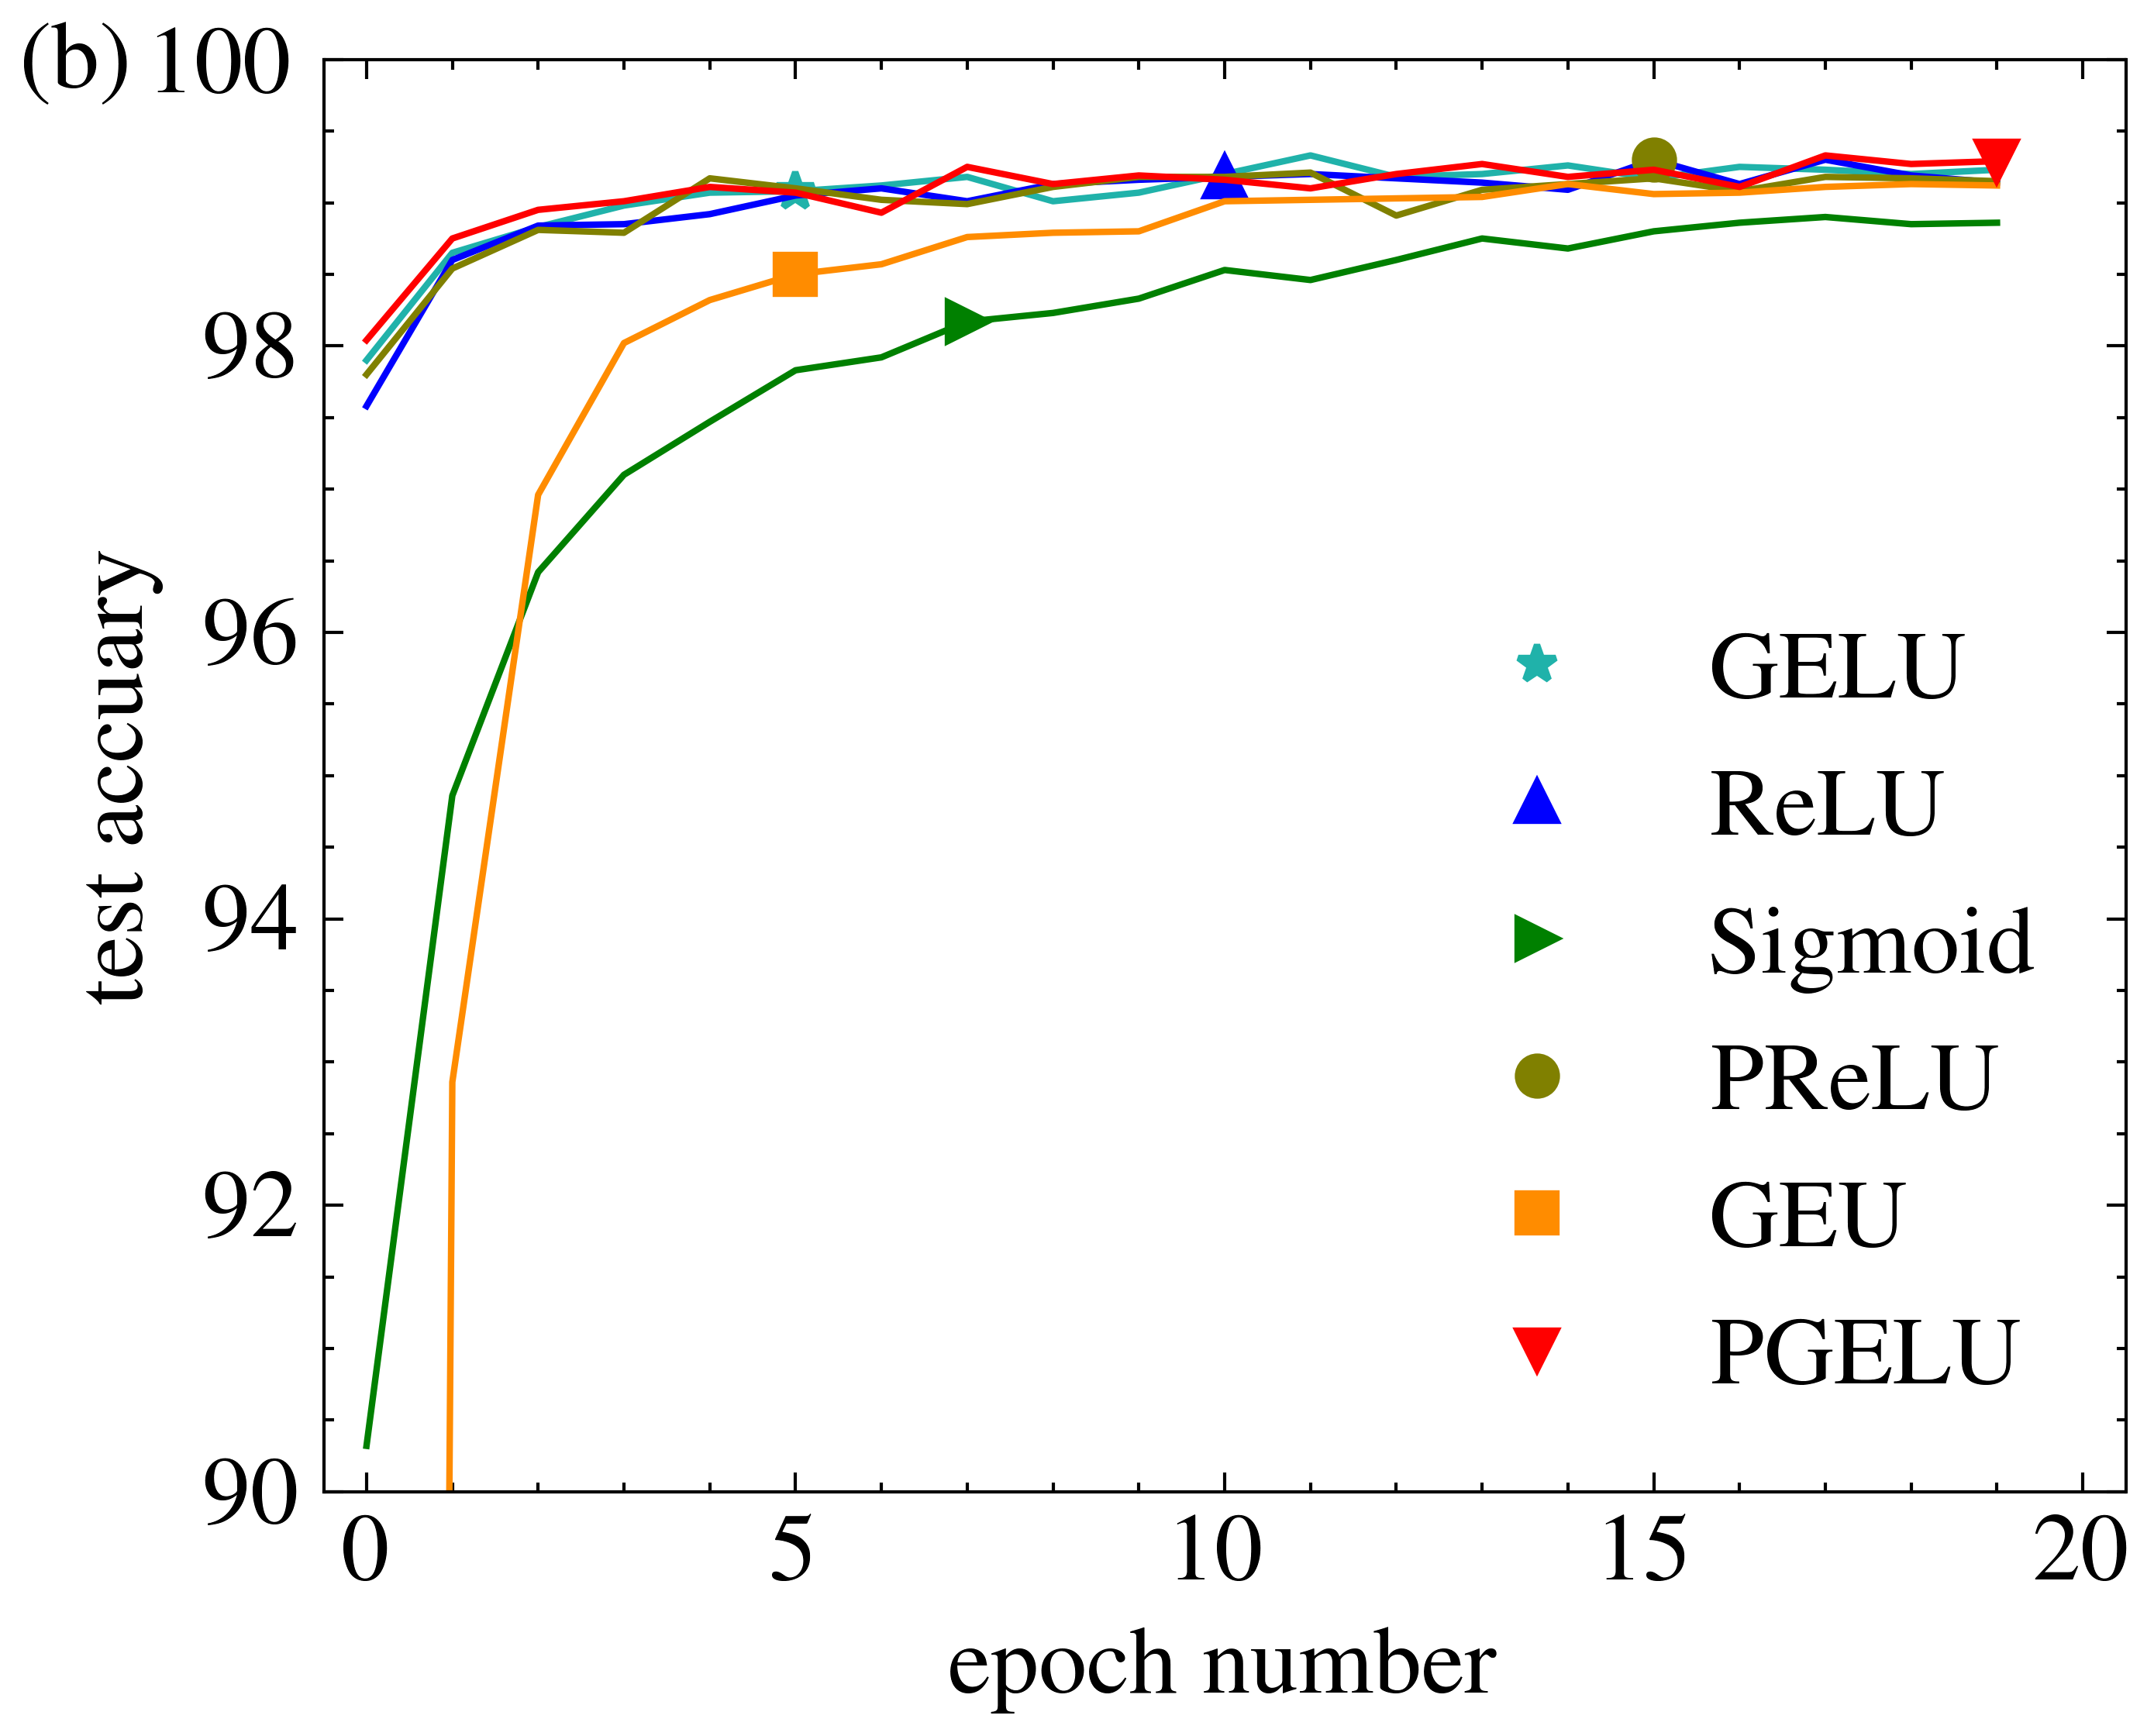

In [44]:
import pandas as pd
historygelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historygelu.csv')
historyrelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historyrelu.csv')
historysigmoid=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historysigmoid.csv')
historyPrelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historyPrelu.csv')
historygeu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historygeu.csv')
historypgelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historypgelu.csv')
import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('test accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(90, 100)

xgelu = range(0, 20)
ygelu = historygelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='lightseagreen')
plt.plot(xgelu[5], ygelu[5], '*',color ='lightseagreen',label='GELU')

xrelu = range(0, 20)
yrelu = historyrelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[10], yrelu[10], '^',color ='b',label='ReLU')

xsigmoid = range(0, 20)
ysigmoid = historysigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='g')
plt.plot(xsigmoid[7], ysigmoid[7], '>',color ='g',label='Sigmoid')

xPrelu = range(0, 20)
yPrelu = historyPrelu['Prelu_valid_acc']
plt.plot(xPrelu, yPrelu, '-',color ='olive')
plt.plot(xrelu[15], yrelu[15], 'o',color ='olive',label='PReLU')


xgeu = range(0, 20)
ygeu = historygeu['geu_valid_acc']
plt.plot(xgeu, ygeu, '-',color ='darkorange')
plt.plot(xgeu[5], ygeu[5], 's',color ='darkorange',label='GEU')

xpgelu = range(0, 20)
ypgelu = historypgelu['pgelu_valid_acc']
plt.plot(xpgelu, ypgelu, '-',color ='r')
plt.plot(xpgelu[19], ypgelu[19], 'v',color ='r',label='PGELU')

ax.legend(loc='lower right', fontsize=15)
ax.text(-4, 99.8, '(b)',fontdict={'size': 15, 'color':  'black'})
plt.show()
fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminstb.eps', dpi=800)

In [31]:
print(historypgelu)

    Unnamed: 0  pgelu_train_loss  pgelu_valid_loss  pgelu_train_acc  \
0            0          0.282892          0.058503        91.516667   
1            1          0.084928          0.038141        97.458333   
2            2          0.060894          0.030308        98.150000   
3            3          0.050490          0.029985        98.397917   
4            4          0.043958          0.028046        98.637500   
5            5          0.036514          0.026359        98.879167   
6            6          0.032115          0.037162        98.985417   
7            7          0.030778          0.027564        99.002083   
8            8          0.028505          0.034380        99.081250   
9            9          0.025187          0.028393        99.218750   
10          10          0.025783          0.030774        99.177083   
11          11          0.022346          0.031321        99.231250   
12          12          0.022608          0.032048        99.264583   
13    

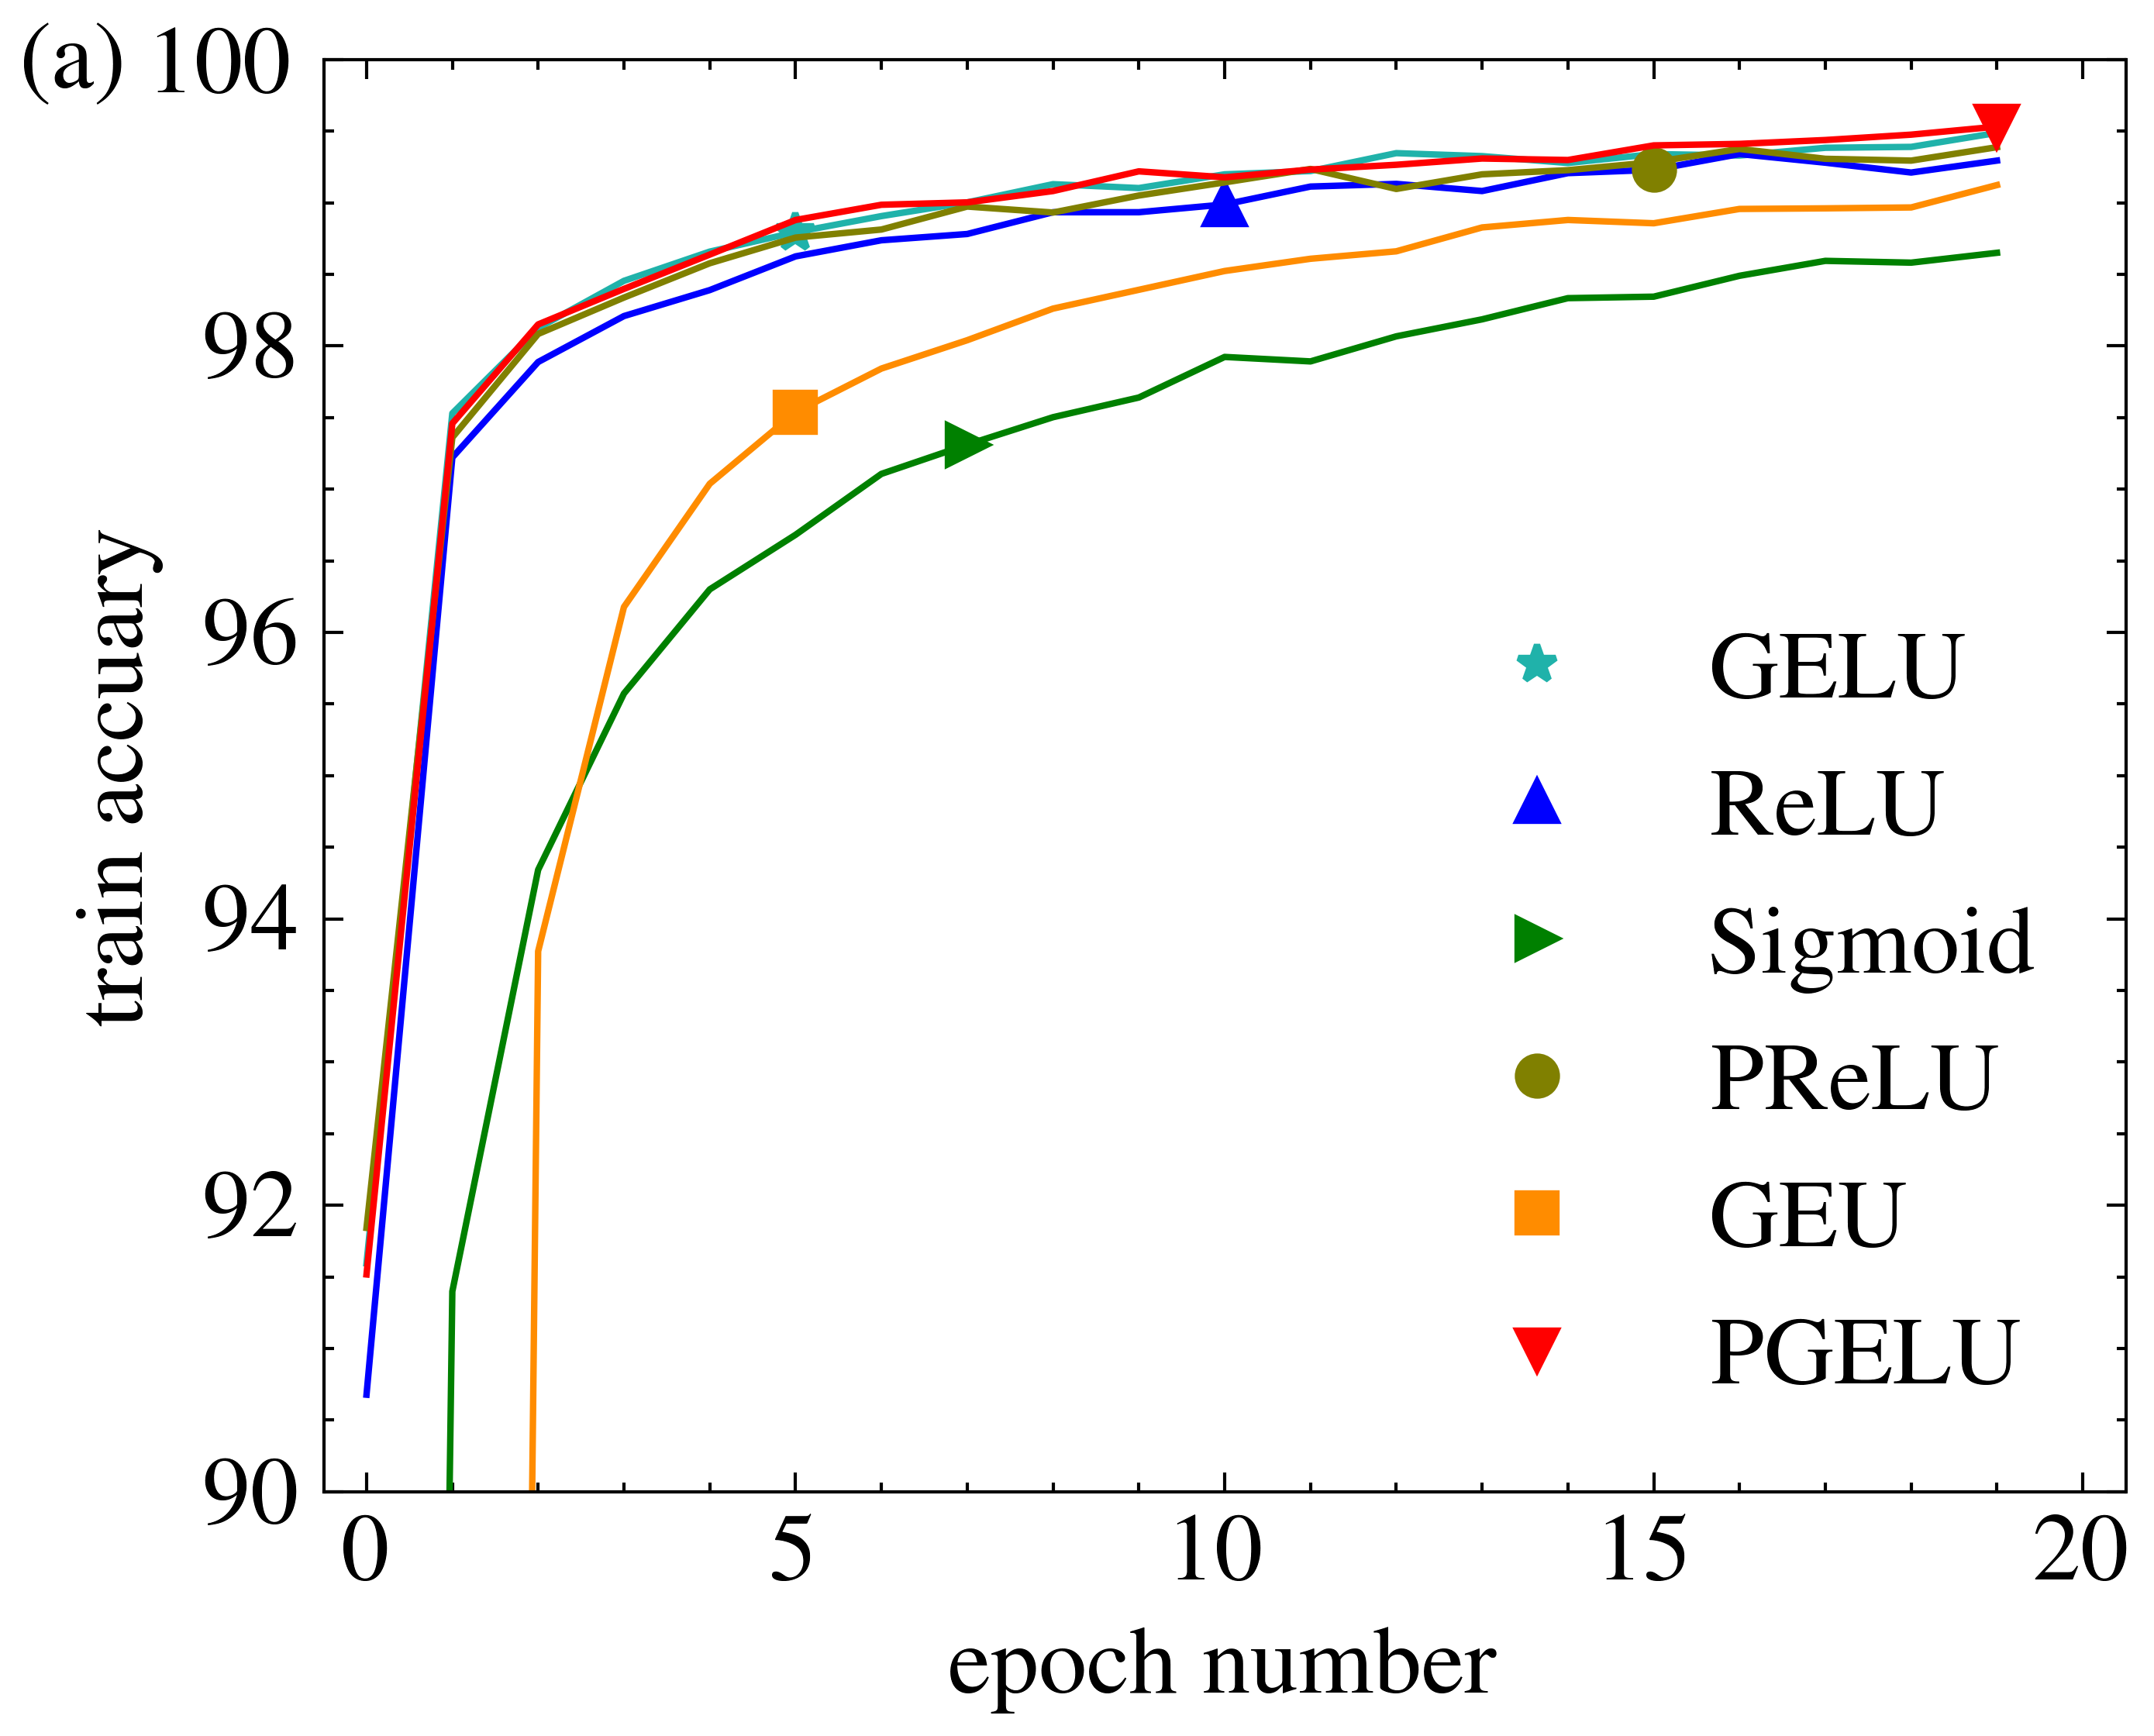

In [45]:
import pandas as pd
historygelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historygelu.csv')
historyrelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historyrelu.csv')
historysigmoid=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historysigmoid.csv')
historyPrelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historyPrelu.csv')
historygeu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historygeu.csv')
historypgelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historypgelu.csv')
import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('train accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(90, 100)

xgelu = range(0, 20)
ygelu = historygelu['GELU_train_acc']
plt.plot(xgelu, ygelu, '-',color ='lightseagreen')
plt.plot(xgelu[5], ygelu[5], '*',color ='lightseagreen',label='GELU')

xrelu = range(0, 20)
yrelu = historyrelu['relu_train_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[10], yrelu[10], '^',color ='b',label='ReLU')

xsigmoid = range(0, 20)
ysigmoid = historysigmoid['SIGMOID_train_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='g')
plt.plot(xsigmoid[7], ysigmoid[7], '>',color ='g',label='Sigmoid')

xPrelu = range(0, 20)
yPrelu = historyPrelu['Prelu_train_acc']
plt.plot(xPrelu, yPrelu, '-',color ='olive')
plt.plot(xrelu[15], yrelu[15], 'o',color ='olive',label='PReLU')


xgeu = range(0, 20)
ygeu = historygeu['geu_train_acc']
plt.plot(xgeu, ygeu, '-',color ='darkorange')
plt.plot(xgeu[5], ygeu[5], 's',color ='darkorange',label='GEU')

xpgelu = range(0, 20)
ypgelu = historypgelu['pgelu_train_acc']
plt.plot(xpgelu, ypgelu, '-',color ='r')
plt.plot(xpgelu[19], ypgelu[19], 'v',color ='r',label='PGELU')

ax.legend(loc='lower right', fontsize=15)
ax.text(-4, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminsta.eps', dpi=800)